# Source re-analysis 

Simpler analysis, relying on ANOVAs and collapsing over encoding side, but **not** task in retrieval analyses.

In [1]:
# Get the username and use that to set-up paths to data and figures
uname  = !whoami
uname = uname[0]
path2code = '/Users/' + uname + '/Work/Expts/Code/'
path2data = '/Users/' + uname + '/Work/Expts/SOURCE/Data/'
path2analysis = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/'
path2figs = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/Figures/'
path2stims = '/Users/' + uname + '/Work/Expts/SOURCE/PsychoPy/Stimuli/'
path2erps = '/Users/' + uname + '/Work/Expts/SOURCE/Analysis/ERPs/'

In [2]:
%cd {path2code}

import csv, misc, os, re, SelfRep
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext rpy2.ipython

%R library('ez')
%R library('mutoss')
%R library('lmerTest')
%R library('lsmeans')
%R lsm.options(disable.pbkrtest=TRUE)
%R library('effsize')
%R library ('afex')

/Users/danieldillon/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/danieldillon/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: mvtnorm

  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading required package: lm

/Users/danieldillon/Work/Expts/Code


/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: - Functions for ANOVAs have been renamed to: aov_car(), aov_ez(), and aov_4().
- ANOVA functions return an object of class 'afex_aov' as default, see: ?aov_car
- 'afex_aov' objects can be passed to lsmeans for contrasts and follow-up tests.
- Reset previous (faster) behavior via: afex_options(return_aov='nice')
- Many more arguments can now be set globally via options, see: afex_options()
************

  warnings.warn(x, RRuntimeWarning)


array(['afex', 'reshape2', 'effsize', 'lsmeans', 'estimability',
       'lmerTest', 'lme4', 'Matrix', 'mutoss', 'mvtnorm', 'ez', 'tools',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'], 
      dtype='|S12')

In [3]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [4]:
sns.set_style('darkgrid')

## Encoding

In [5]:
# Assemble the trial-level encoding data . . . 

%cd {path2data}

e_dfs = []
ef_d = re.compile('Source_enc')

subjects = !ls -d SM0*

for subject in subjects:
    curr_path = path2data + subject
    for root, dirs, files in os.walk(curr_path):
        for filename in files:
            ef_m = ef_d.search(filename)
            if ef_m:
                file_path = curr_path + '/CSV/' + filename
                e_df = pd.read_csv(file_path)
                e_df['subject'] = subject
                e_dfs.append(e_df)
                
enc_data = pd.concat(e_dfs)
enc_data.RT = enc_data.RT.map(lambda x : np.nan if x < 0 else x) # Set RT to np.nan if negative (e.g., SM045, SM046)

/Users/danieldillon/Work/Expts/SOURCE/Data


In [6]:
# Assemble self-report and demographics
demo = SelfRep.demo_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
bdi = SelfRep.bdi_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
masq = SelfRep.masq_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
rsq = SelfRep.rsq_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
psqi = SelfRep.psqi_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')
wtar = SelfRep.wtar_proc(path2data + 'SOURCE_SelfReport_Data.xlsx')

sr = pd.merge(left=demo,right=bdi,left_on='subject',right_on='subject')
sr = pd.merge(left=sr,right=masq,left_on='subject',right_on='subject')
sr = pd.merge(left=sr,right=rsq,left_on='subject',right_on='subject')
sr = pd.merge(left=sr,right=psqi,left_on='subject',right_on='subject')
sr = pd.merge(left=sr,right=wtar,left_on='subject',right_on='subject')

SelfRep.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
SelfRep.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
SelfRep.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
SelfRep.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [7]:
# Merge the encoding and self-report data, then drop subjects based on the MINI
all_subs = pd.merge(enc_data,sr,on='subject')
del all_subs['Notes']
all_subs.Group = all_subs.Group.astype(int)
all_subs.Gender = all_subs.Gender.astype(str)
all_subs.Race = all_subs.Race.astype(str)
all_subs['Highest Degree'] = all_subs['Highest Degree'].astype(str)
all_subs.Occupation = all_subs.Occupation.astype(str)
all_subs.Income = all_subs.Income.astype(str)
all_subs.Inclusion = all_subs.Inclusion.astype(int)
enc = all_subs[all_subs.Inclusion == 1]

In [8]:
# Number of usable subjects per group (not taking ERP data quality into account)
enc.groupby('Group')['subject'].nunique()

Group
0    34
1    26
Name: subject, dtype: int64

In [9]:
# List of participants with usable ERPs
erpSubs_all = ['SM011', 'SM013', 'SM014', 'SM017', 'SM018', 'SM019', 'SM021', 'SM022', 
               'SM023', 'SM024', 'SM028', 'SM032', 'SM040', 'SM041', 'SM042', 'SM043', 
               'SM044', 'SM045', 'SM056', 'SM058', 'SM070', 'SM072', 'SM036', 'SM035', 
               'SM015', 'SM026', 'SM031', 'SM037', 'SM038', 'SM039', 'SM046', 'SM047', 
               'SM048', 'SM049', 'SM050', 'SM051', 'SM055', 'SM059', 'SM060', 'SM062', 
               'SM063', 'SM064', 'SM066', 'SM067', 'SM069', 'SM071', 'SM073', 'SM074']

In [10]:
# Track encoding accuracy and add to df
d = {}
d[1] = {'vitality': 'living', 'mobility': 'immobile'}
d[2] = {'vitality': 'non-living', 'mobility': 'immobile'}
d[3] = {'vitality': 'living', 'mobility': 'mobile'}
d[4] = {'vitality': 'non-living', 'mobility': 'mobile'}

accuracy = []
for i, row_i in enc.iterrows():
    if row_i.response == 'no_response':
        accuracy.append(999)
    elif row_i.response in d[row_i.type].values():
        accuracy.append(1)
    else:
        accuracy.append(0)
enc['accuracy'] = accuracy
enc.task = enc.task.replace(to_replace={'living_non-living':'animacy','mobile_immobile':'mobility'})
enc.Group = enc.Group.replace(to_replace={0:'control',1:'MDD'})
enc.rename(columns={'Group':'group'},inplace=True)
enc['RT (ms)'] = 1000*enc.RT

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/danieldillon/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/danieldillon/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/index

In [11]:
enc_clean = enc[~(enc.accuracy == 999)] # Was having difficulty dropping NaNs for accuracy . . . 

In [12]:
# Okay, since we're very much focused on the ERP group, I'm running with data analysis on the ERP subs.
# Maybe when I'm done I will confirm with the larger group (but since their ERPs are bad their behavior may be bad)
erp_enc = enc_clean[enc_clean.subject.isin(erpSubs_all)]
erp_enc.groupby('group')['subject'].nunique()

group
MDD        24
control    24
Name: subject, dtype: int64

/Users/danieldillon/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


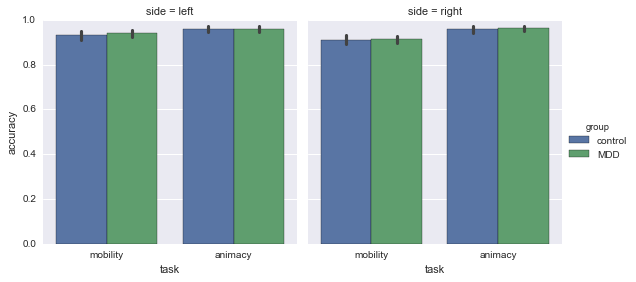

In [13]:
sns.factorplot(y='accuracy',x='task',hue='group',col='side',units='subject',ci=68,kind='bar',data=erp_enc)
sns.plt.savefig(path2figs + 'Enc_acc.pdf')

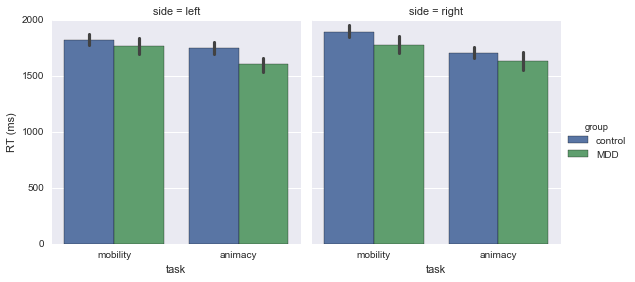

In [14]:
# RT
sns.factorplot(y='RT (ms)',x='task',hue='group',col='side',units='subject',ci=68,kind='bar',data=erp_enc)

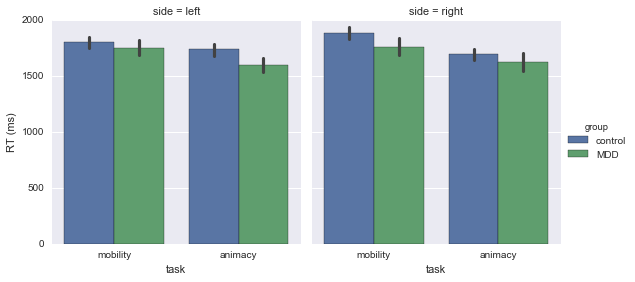

In [15]:
# Accuracy is so high that limiting RT to correct responses probably won't make much difference, but let's check.
# Nope, not much different . . . 
sns.factorplot(y='RT (ms)',x='task',hue='group',col='side',units='subject',ci=68,kind='bar',
               data=erp_enc[erp_enc.accuracy == 1])
sns.plt.savefig(path2figs + 'Enc_corr_RT.pdf')

In [16]:
# ANOVA on encoding accuracy; only effect is Task

%Rpush erp_enc
# %R str(erp_enc)

%R enc_acc.aov <- aov_ez(id='subject', dv='accuracy', within=c('task','side'), between='group', data=erp_enc)
%R print(enc_acc.aov)

/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: accuracy
           Effect    df  MSE         F    ges p.value
1           group 1, 46 0.01      0.05  .0006     .82
2            task 1, 46 0.00 12.70 ***    .07   .0009
3      group:task 1, 46 0.00      0.05  .0003     .83
4            side 1, 46 0.00    3.67 +   .008     .06
5      group:side 1, 46 0.00      0.00 <.0001     .99
6       task:side 1, 46 0.00    3.26 +   .009     .08
7 group:task:side 1, 46 0.00      0.18  .0005     .67

Sphericity correction method: GG 


In [17]:
# Give me the descriptives by task
g = erp_enc.groupby(['subject','task'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()
print 100*(df.groupby('task')['accuracy'].mean())
print 100*(df.groupby('task')['accuracy'].std())

task
animacy     95.872667
mobility    92.357490
Name: accuracy, dtype: float64
task
animacy     4.871214
mobility    6.256944
Name: accuracy, dtype: float64


In [18]:
# To compute effect size with Cohen's d using R, need to aggregate w/in subs first
g = erp_enc.groupby(['subject','task'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
print df.groupby('task')['accuracy'].mean()
print df.groupby('task')['accuracy'].std()
# sp.stats.pearsonr(df[df.task == 'mobile_immobile']['accuracy'],df[df.task == 'living_non-living']['accuracy'])
df.head()

%Rpush df
%R str(df)
%R enc_acc.es <- cohen.d(accuracy ~ task, data=df, paired=TRUE)
%R print(enc_acc.es)

task
animacy     0.958727
mobility    0.923575
Name: accuracy, dtype: float64
task
animacy     0.048712
mobility    0.062569
Name: accuracy, dtype: float64


'data.frame':	96 obs. of  3 variables:
 $ subject : Factor w/ 48 levels "SM011","SM013",..: 1 1 2 2 3 3 4 4 5 5 ...
 $ task    : Factor w/ 2 levels "animacy","mobility": 1 2 1 2 1 2 1 2 1 2 ...
 $ accuracy: num  0.872 0.896 0.936 0.841 0.979 ...



Cohen's d

d estimate: 0.4643757 (small)
95 percent confidence interval:
       inf        sup 
0.04919401 0.87955732 


In [19]:
# ANOVA on encoding RT (correct trials only, as in IGD & AW, 2005). This gives an effect of Task and a 
# Group x Task x Side interaction.

erp_enc_corr = erp_enc[erp_enc.accuracy == 1]
erp_enc_corr = erp_enc_corr[~((erp_enc_corr.subject == 'SM045') | (erp_enc_corr.subject == 'SM046'))]

%Rpush erp_enc_corr

%R enc_rt.aov <- aov_ez(id='subject', dv='RT', within=c('task','side'), between='group',data=erp_enc_corr)
%R print(enc_rt.aov)

Anova Table (Type 3 tests)

Response: RT
           Effect    df  MSE         F    ges p.value
1           group 1, 44 0.32      1.43    .03     .24
2            task 1, 44 0.02 54.34 ***    .05  <.0001
3      group:task 1, 44 0.02      0.31  .0003     .58
4            side 1, 44 0.01      2.49   .001     .12
5      group:side 1, 44 0.01      0.01 <.0001     .94
6       task:side 1, 44 0.01    2.91 +   .002     .09
7 group:task:side 1, 44 0.01    6.40 *   .004     .02

Sphericity correction method: GG 


In [20]:
# Compute effect size for RT, again aggregating w/in subs first
g = erp_enc_corr.groupby(['subject','task'])['RT'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
print 1000*(df.groupby('task')['RT'].mean())
print 1000*(df.groupby('task')['RT'].std())
df.head()

%Rpush df
%R str(df)
%R enc_rt.es <- cohen.d(RT ~ task, data=df, paired=T)
%R print(enc_rt.es)

task
animacy     1669.104595
mobility    1808.675773
Name: RT, dtype: float64
task
animacy     289.831544
mobility    290.846999
Name: RT, dtype: float64


'data.frame':	92 obs. of  3 variables:
 $ subject: Factor w/ 46 levels "SM011","SM013",..: 1 1 2 2 3 3 4 4 5 5 ...
 $ task   : Factor w/ 2 levels "animacy","mobility": 1 2 1 2 1 2 1 2 1 2 ...
 $ RT     : num  1.39 1.59 1.76 2.09 1.78 ...



Cohen's d

d estimate: -0.3048464 (small)
95 percent confidence interval:
       inf        sup 
-0.7261535  0.1164608 


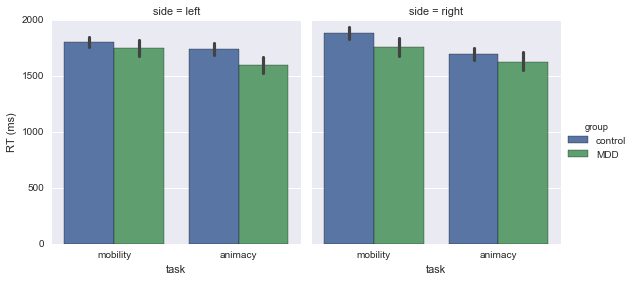

In [21]:
# Interaction seems to reflect a bigger difference in RT by task for MDDs vs. controls on left side vs. right,
# but the GxT is not significant under either side considered separately, see below.

sns.factorplot(y='RT (ms)',x='task',hue='group',col='side',units='subject',ci=68,kind='bar',data=erp_enc_corr)

In [22]:
# Okay, so let's look for Group x Task at each level of Side. Left first; no Group x Task here.

left = erp_enc_corr[erp_enc_corr.side == 'left']

%Rpush left

%R left_rt.aov <- aov_ez(id='subject',dv='RT', within='task', between='group', data=left)
%R print(left_rt.aov)

Anova Table (Type 3 tests)

Response: RT
      Effect    df  MSE         F  ges p.value
1      group 1, 44 0.15      1.57  .03     .22
2       task 1, 44 0.01 22.57 ***  .04  <.0001
3 group:task 1, 44 0.01    3.68 + .007     .06

Sphericity correction method: GG 


In [23]:
# Now right . . . no significant Group x Task here either.

right = erp_enc_corr[erp_enc_corr.side == 'right']

%Rpush right

%R right_rt.aov <- aov_ez(id='subject',dv='RT', within='task', between='group', data=right)
%R print(right_rt.aov)

Anova Table (Type 3 tests)

Response: RT
      Effect    df  MSE         F  ges p.value
1      group 1, 44 0.18      1.24  .03     .27
2       task 1, 44 0.01 50.23 ***  .07  <.0001
3 group:task 1, 44 0.01      1.22 .002     .27

Sphericity correction method: GG 


**Summary:** at encoding, everyone is slower and less accurate for mobility vs. animacy judgments. There are no reliable group differences, but if anything, the MDD group is a little quicker.

## Retrieval

In [24]:
# Response options:
# 'Question': 1 = sure living/non-living, 2 = prob living/non-living, 4 = prob mobile/immobile, 5 = sure mob/immob
# 'Side': 1 = sure left, 2 = prob left, 4 = prob right, 5 = sure right
# 'Odd_even': 1 = sure odd, 2 = prob odd, 4 = prob even, 5 = sure even
# 3 = guess for all prompts

# Conditions:
# 1 = left/living_non-living
# 2 = right/living_non-living
# 3 = left/mobile_immobile
# 4 = right/mobile_immobile

def CompAcc(trialtype):
    
    prompt, condition, response = trialtype
    
    CondDict = {1 : 'left/living_non-living', 2 : 'right/living_non-living',
                3 : 'left/mobile_immobile', 4 : 'right/mobile_immobile',
                5 : 'odd', 6 : 'even'}
    
    RespDicts = {'Question' : {1 : 'living_non-living', 2 : 'living_non-living', 3 : 'guess',
                                4 : 'mobile_immobile', 5 : 'mobile_immobile', 999 : 'no_response'},
                'Side' : {1 : 'left', 2 : 'left', 3 : 'guess', 4 : 'right', 5 : 'right', 999 : 'no_response'},
                'Odd_even' : {1 : 'odd', 2 : 'odd', 3 : 'guess', 4 : 'even', 5 : 'even', 999 : 'no_response'}}
    
    if response == 1 or response == 5:
        Confidence = 'high'
    elif response == 2 or response == 4:
        Confidence = 'low'
    elif response == 3 or response == 999:
        Accuracy = np.nan
        Confidence = np.nan 
        
    CurrCond = CondDict[condition]
    CurrResp = RespDicts[prompt][response]
    
    if '/' in CurrCond:
        ActualSide = CurrCond.split('/')[0]
        ActualTask = CurrCond.split('/')[1]
    
    else:
        Parity = CurrCond
          
    if CurrResp != 'guess' and CurrResp != 'no_response':
        if prompt == 'Odd_even':
            if Parity == CurrResp:
                Accuracy = 1
            elif Parity != CurrResp:
                Accuracy = 0
    
        elif prompt == 'Question' and ActualTask == CurrResp:
            Accuracy = 1

        elif prompt == 'Question' and ActualTask != CurrResp:
            Accuracy = 0

        elif prompt == 'Side' and ActualSide == CurrResp:
            Accuracy = 1

        elif prompt == 'Side' and ActualSide != CurrResp:
            Accuracy = 0

    return (Accuracy,Confidence)

In [25]:
# Assemble the retrieval dataframe.
%cd {path2data}
subjects = !ls -d SM0*

r_dfs = []
rf_d = re.compile('Source_ret')

for subject in subjects:
    curr_path = path2data + subject
    for root, dirs, files in os.walk(curr_path):
        for filename in files:
            rf_m = rf_d.search(filename)
            if rf_m:
                file_path = curr_path + '/CSV/' + filename
                r_df = pd.read_csv(file_path)
                r_df['subject'] = subject
                r_dfs.append(r_df)
                
ret_data = pd.concat(r_dfs)
ret_data.RT = ret_data.RT.map(lambda x: np.nan if x <0 else x) # 45 and 46 are still in, but dropna will remove them

# Code accuracy
ret_data['accuracy'], ret_data['confidence'] = zip(*ret_data[['prompt','condition','response']].apply(CompAcc, axis=1))

# Mark outliers, mean +/- 3SDs
dfs = []
for sub in ret_data.subject.unique():
    outlier = []
    df = ret_data[ret_data.subject == sub]
    for i, row_i in df.iterrows():
        if np.isnan(row_i.RT):
            outlier.append(np.nan)
        elif abs(row_i.RT-df.RT.mean()) <= df.RT.std()*3:
            outlier.append(0)
        else:
            outlier.append(1)
    df['outlier'] = outlier
    dfs.append(df)
ret = pd.concat(dfs)

print "Number of retrieval trials that are not (0) outliers vs. are (1) outliers:"
print ret.outlier.value_counts()

# Count number of trials with no response, drop them, and drop outliers.
print "Number of retrieval trials with no response: " + str(len(ret[ret.RT == 999])) 
ret_clean = ret[~((ret.RT == 999) | (ret.outlier == 1))]

ret_clean.to_csv(path2analysis + 'ret_clean.csv',index=False)

/Users/danieldillon/Work/Expts/SOURCE/Data
Number of retrieval trials that are not (0) outliers vs. are (1) outliers:
0    16997
1      283
Name: outlier, dtype: int64
Number of retrieval trials with no response: 10


/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
# Merge the retrieval and self-report data
ret = pd.merge(ret_clean,sr,on='subject')
ret = ret[~(ret.Inclusion == 0)] # Drop subjects who should be excluded based on MINI

# Fix dtype issues
del ret['Notes']
ret.Group = ret.Group.astype(int)
ret.Gender = ret.Gender.astype(str)
ret.Race = ret.Race.astype(str)
ret['Highest Degree'] = ret['Highest Degree'].astype(str)
ret.Occupation = ret.Occupation.astype(str)
ret.Income = ret.Income.astype(str)
ret.Inclusion = ret.Inclusion.astype(int)
ret.confidence = ret.confidence.astype(str)

# Rename a couple things
ret.rename(columns={'Group':'group','Gender':'gender','prompt':'cue'},inplace=True)

# Add guesses
ret['guess'] = ret.response.map(lambda x: 1 if x == 3 else 0)

# Go with group names rather than numbers
ret.group = ret.group.replace(to_replace={0:'control',1:'MDD'})

# And grab just those subjects with clean ERP data
erp_ret = ret[ret.subject.isin(erpSubs_all)]

In [27]:
# We need to know which words were encoded on the left vs. right and with what question. 
# This information is contained in "condition" but let's make columns with more obvious names.

def EncodingCondition(value):

    CondDict = {1 : 'left/living_non-living', 2 : 'right/living_non-living',
                3 : 'left/mobile_immobile', 4 : 'right/mobile_immobile'}
    
    if value == 5 or value == 6: # These are odd/even trials
        side = 'none'
        question = 'none'
    else:
        condition = CondDict[value]
        side = condition.split('/')[0]
        question = condition.split('/')[1]
        if question == 'living_non-living':
            question = 'animacy'
        elif question == 'mobile_immobile':
            question = 'mobility'
    
    return (side, question)

erp_ret['encoding_location'],erp_ret['encoding_task'] = zip(*erp_ret.condition.map(EncodingCondition))

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [28]:
erp_ret.groupby('group')['subject'].nunique()

group
MDD        24
control    24
Name: subject, dtype: int64

### Guesses 

IGD pointed to the guesses and wants to know if there are group differences there. Let's look at that again here. Guesses were response 3, which yielded accuracy = 999.

In [29]:
# First, let's see how many people there are with no guesses. We can do that by subtracting out the number of people
# with guesses . . . 
guess = erp_ret[erp_ret.response == 3]
g = guess.groupby(['subject','group','cue','encoding_task'])['response'].value_counts()
df = g.to_frame()
df.reset_index(inplace=True)
cols = ['subject','group','cue','encoding_task','response','count']
df.columns = cols
df = df[['subject','group','cue','encoding_task','count']]
df.head()

,subject,group,cue,encoding_task,count
0,SM011,control,Question,mobility,1
1,SM011,control,Side,mobility,1
2,SM013,control,Question,animacy,5
3,SM013,control,Question,mobility,2
4,SM013,control,Side,animacy,5


In [30]:
# Since this df is based on the erp_ret trials where the response was guess, the fact that there are no Odd/Even cues
# implies that nobody ever guessed on Odd/Even trials. Here are two ways to confirm that . . . 
print df.cue.unique()

s_guess = 0
q_guess = 0
n_guess = 0

for i, row_i in erp_ret.iterrows():
    if row_i.response == 3 and row_i.cue == 'Side':
        s_guess = s_guess + 1
    elif row_i.response == 3 and row_i.cue == 'Question':
        q_guess = q_guess + 1
    elif row_i.response == 3 and row_i.cue == 'Odd_even':
        n_guess = n_guess + 1

print 'The number of Side guesses = ' + str(s_guess)
print 'The number of Question guesses = ' + str(q_guess)
print 'The number of Odd/Even guesses = ' + str(n_guess)

['Question' 'Side']
The number of Side guesses = 523
The number of Question guesses = 358
The number of Odd/Even guesses = 0


In [31]:
# Okay, since the df above only holds data for people who've guessed, let's use that to figure out who never guessed.
# Since there are 24 people per group, this implies that 3 controls and 2 MDDs never guessed.
df.groupby('group')['subject'].nunique()

group
MDD        22
control    21
Name: subject, dtype: int64

In [32]:
# For the ANOVA, we're going to need a df that includes only subjects who guessed at least once for each task and cue.
# Also, get a count of subjects who did not guess in at least one of the four conditions defined by (Cue x Task). 

mdd_ct = 0
hc_ct = 0
no_guesses = []

for sub in df.subject.unique():
    num = int(df[df.subject == sub]['subject'].value_counts())
    if num != 4: # There are 4 conditions (2 Cues x 2 Task) and we're looking for people who don't have all 4
        sdf = df[df.subject == sub]
        sdf.reset_index(inplace=True,drop=True)
        group = sdf.group.ix[0]
        if group == 'control':
            hc_ct = hc_ct + 1
        elif group == 'MDD':
            mdd_ct = mdd_ct + 1
        no_guesses.append(sub)
print "There are " + str(hc_ct) + " controls and " + str(mdd_ct) + " depressed adults who did not guess in response \
to the Question or the Side cue, or both."

nog = df[df['subject'].isin(no_guesses)]
nog['count'].describe() # Shows that the people who did not guess in at least one condition did not guess much overall.

There are 10 controls and 5 depressed adults who did not guess in response to the Question or the Side cue, or both.


count    36.000000
mean      3.500000
std       3.459975
min       1.000000
25%       1.000000
50%       2.000000
75%       5.000000
max      14.000000
Name: count, dtype: float64

Putting together the 3 controls who never guessed and the 10 controls who did not guess in at least 1 condition, we have 11 controls with guesses in all 4 conditions (Cue x Task). For the MDDs, there were 2 who never guessed and 5 who did not guess in at least 1 condition, which leaves 17 who guessed at least once in all 4 conditions. So we're going to be graphing and running ANOVAs on guess data from HC = 11 and MDD = 17.

In [33]:
df.head()

,subject,group,cue,encoding_task,count
0,SM011,control,Question,mobility,1
1,SM011,control,Side,mobility,1
2,SM013,control,Question,animacy,5
3,SM013,control,Question,mobility,2
4,SM013,control,Side,animacy,5


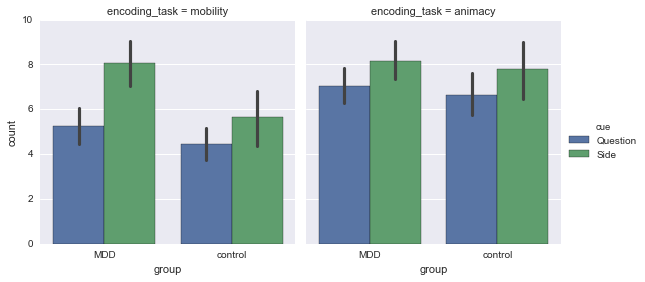

In [34]:
# Now plot the guess data, excluding the subjects with no guesses in one more more condition
# So looks like the MDDs guess more, everybody guesses more under Side vs. Question. Notice that MDDs guess 
# least for Q/MI.

df = df[~(df['subject'].isin(no_guesses))]
sns.factorplot(y='count',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',data=df,
              order = ['MDD','control'], col_order=['mobility','animacy'])
sns.plt.savefig(path2figs + 'Guessing_GxCxT.pdf')

In [35]:
# Let's get the descriptives there in case we want to use a table instead of a graph
print df.groupby(['group','cue','encoding_task'])['count'].mean()
print df.groupby(['group','cue','encoding_task'])['count'].std()

group    cue       encoding_task
MDD      Question  animacy          7.058824
                   mobility         5.235294
         Side      animacy          8.176471
                   mobility         8.058824
control  Question  animacy          6.636364
                   mobility         4.454545
         Side      animacy          7.818182
                   mobility         5.636364
Name: count, dtype: float64
group    cue       encoding_task
MDD      Question  animacy          3.381394
                   mobility         3.363953
         Side      animacy          3.450277
                   mobility         4.436646
control  Question  animacy          3.294624
                   mobility         2.583162
         Side      animacy          4.400413
                   mobility         4.006812
Name: count, dtype: float64


In [36]:
# ANOVA on guesses; effects of Cue and Task, people guessed more in to Side vs. Question and for Animacy vs. Mobility.
# No effect of Group, no interactions.

%Rpush df
# %R str(df)

%R guess.aov <- aov_ez(id='subject',dv='count', within=c('cue','encoding_task'), between='group', data=df)
%R print(guess.aov)

Anova Table (Type 3 tests)

Response: count
                   Effect    df   MSE        F  ges p.value
1                   group 1, 26 35.43     0.75  .02     .40
2                     cue 1, 26  9.34   7.11 *  .05     .01
3               group:cue 1, 26  9.34     0.44 .003     .51
4           encoding_task 1, 26  5.38 12.34 **  .05    .002
5     group:encoding_task 1, 26  5.38     1.82 .007     .19
6       cue:encoding_task 1, 26  3.65     1.33 .003     .26
7 group:cue:encoding_task 1, 26  3.65     1.33 .003     .26

Sphericity correction method: GG 


In [37]:
# Give me descriptives for the main effect of Cue
print df.groupby('cue')['count'].mean()
print df.groupby('cue')['count'].std()

cue
Question    5.910714
Side        7.571429
Name: count, dtype: float64
cue
Question    3.298908
Side        4.071440
Name: count, dtype: float64


In [38]:
# Now descriptives for the main effect of Task
print df.groupby('encoding_task')['count'].mean()
print df.groupby('encoding_task')['count'].std()

encoding_task
animacy     7.464286
mobility    6.017857
Name: count, dtype: float64
encoding_task
animacy     3.557140
mobility    3.891674
Name: count, dtype: float64


In [39]:
df.head()

,subject,group,cue,encoding_task,count
2,SM013,control,Question,animacy,5
3,SM013,control,Question,mobility,2
4,SM013,control,Side,animacy,5
5,SM013,control,Side,mobility,6
16,SM022,control,Question,animacy,6


In [40]:
# I bet there are fewer Q vs. S guesses for MI words in MDDs but no other within wordtype cue effects.
# Yup.
misc.ttest_2s(df[(df.group == 'MDD') & (df.encoding_task == 'mobility') & (df.cue == 'Question')]['count'],
              df[(df.group == 'MDD') & (df.encoding_task == 'mobility') & (df.cue == 'Side')]['count'],
              paired=True)

misc.ttest_2s(df[(df.group == 'MDD') & (df.encoding_task == 'animacy') & (df.cue == 'Question')]['count'],
              df[(df.group == 'MDD') & (df.encoding_task == 'animacy') & (df.cue == 'Side')]['count'],
              paired=True)

misc.ttest_2s(df[(df.group == 'control') & (df.encoding_task == 'mobility') & (df.cue == 'Question')]['count'],
              df[(df.group == 'control') & (df.encoding_task == 'mobility') & (df.cue == 'Side')]['count'],
              paired=True)

misc.ttest_2s(df[(df.group == 'control') & (df.encoding_task == 'animacy') & (df.cue == 'Question')]['count'],
              df[(df.group == 'control') & (df.encoding_task == 'animacy') & (df.cue == 'Side')]['count'],
              paired=True)

# Check to see if the guessing rate for Q/MI words is lower than for all other cells of the design for MDDs
misc.ttest_2s(df[(df.group == 'MDD') & (df.encoding_task == 'mobility') & (df.cue == 'Question')]['count'],
              df[(df.group == 'MDD') & (df.encoding_task == 'animacy') & (df.cue == 'Question')]['count'],
              paired=True)

misc.ttest_2s(df[(df.group == 'MDD') & (df.encoding_task == 'mobility') & (df.cue == 'Question')]['count'],
              df[(df.group == 'MDD') & (df.encoding_task == 'animacy') & (df.cue == 'Side')]['count'],
              paired=True)

# all this shows that MDDs guessed less in Q/MI than in any other cell.

t(16) = -3.11, p = 0.007
t(16) = -1.29, p = 0.215
t(10) = -1.32, p = 0.215
t(10) = -0.98, p = 0.350
t(16) = -3.00, p = 0.008
t(16) = -3.09, p = 0.007


(-3.0868020396236426, 0.0070726826411804103)

In [41]:
df.head()

,subject,group,cue,encoding_task,count
2,SM013,control,Question,animacy,5
3,SM013,control,Question,mobility,2
4,SM013,control,Side,animacy,5
5,SM013,control,Side,mobility,6
16,SM022,control,Question,animacy,6


In [42]:
# Compute effect sizes for the guessing comparisons in the MDD group as they are significant
mdd_guess = df[df.group == 'MDD']

%Rpush mdd_guess
%R str(mdd_guess)
%R QMI_v_SMI.es <- cohen.d(count ~ cue, data=subset(mdd_guess, encoding_task=='mobility'), paired=TRUE)
%R QMI_v_QLNL.es <- cohen.d(count ~ encoding_task, data=subset(mdd_guess, cue=='Question'), paired=TRUE)
%R QMI <- subset(mdd_guess, encoding_task=='mobility' & cue=='Question')
%R SLNL <- subset(mdd_guess, encoding_task=='animacy' & cue=='Side')
%R QMI_v_SLNL.es <- cohen.d(QMI$count, SLNL$count, paired=TRUE)

%R print(QMI_v_SMI.es)
%R print(QMI_v_QLNL.es)
%R print(QMI_v_SLNL.es)

'data.frame':	68 obs. of  5 variables:
 $ subject      : Factor w/ 17 levels "SM026","SM031",..: 1 1 1 1 2 2 2 2 3 3 ...
 $ group        : Factor w/ 1 level "MDD": 1 1 1 1 1 1 1 1 1 1 ...
 $ cue          : Factor w/ 2 levels "Question","Side": 1 1 2 2 1 1 2 2 1 1 ...
 $ encoding_task: Factor w/ 2 levels "animacy","mobility": 1 2 1 2 1 2 1 2 1 2 ...
 $ count        : int  3 1 7 2 6 5 5 3 6 4 ...



Cohen's d

d estimate: -0.5082069 (medium)
95 percent confidence interval:
       inf        sup 
-1.2406190  0.2242052 



Cohen's d

d estimate: 0.3782422 (small)
95 percent confidence interval:
       inf        sup 
-0.3487323  1.1052167 



Cohen's d

d estimate: -0.7486595 (medium)
95 percent confidence interval:
         inf          sup 
-1.495147668 -0.002171256 


So the **bottom line for guesses** is that everyone guessed more in response to Side versus Question cue and in response to words from the animacy vs. mobility task, and the combination of Question/mobility led to especially few guesses in MDD.

### Accuracy 

#### Odd/Even 

We are ultimately going to want to run Group x Cue x Task, and since there is no Task when Cue == Odd_even, we're going to have to drop the Odd/Even trials from the analysis. But first let's look at the accuracy data from those trials, to see whether there are any group differences.

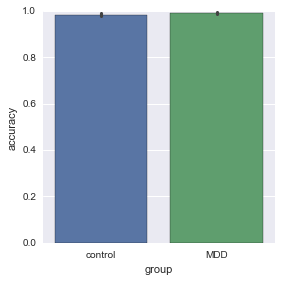

In [43]:
# Shows that both groups are extremely accurate on Odd/Even trials 
oe = erp_ret[erp_ret.cue == 'Odd_even']
sns.factorplot(y='accuracy',x='group',units='subject',ci=68,kind='bar',data=oe)

In [44]:
# T-test on the group difference in accuracy on Odd/Even trials, no difference.
g = oe.groupby(['group','subject'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
print 100*(df.groupby('group')['accuracy'].mean())
print 100*(df.groupby('group')['accuracy'].std())
misc.ttest_2s(df[df.group == 'control']['accuracy'],df[df.group == 'MDD']['accuracy'])

group
MDD        99.131944
control    98.423784
Name: accuracy, dtype: float64
group
MDD        1.362214
control    3.963357
Name: accuracy, dtype: float64
t(46) = -0.83, p = 0.412


(-0.8278041907455097, 0.41205557739647902)

#### Group x Cue x Task 

Okay, for the rest of the accuracy analysis we want to exclude the Odd/Even trials. So let's set up a df without those.

In [45]:
noe = erp_ret[~(erp_ret.cue == 'Odd_even')]
noe.reset_index(inplace = True,drop=True)
noe.head()

,subject,run,trial,cue,item,condition,response,RT,iti_dur(ms),accuracy,...,PSQI_DayDys,PSQI_Efficiency,PSQI_Quality,PSQI_Medication,PSQI_Total,WTAR_NatEng,WTAR_StdScore,guess,encoding_location,encoding_task
0,SM011,1,2,Question,desk,4,1,3.201,501,0,...,0,0,0,0,1,yes,89,0,right,mobility
1,SM011,1,3,Question,fern,1,1,0.784,501,1,...,0,0,0,0,1,yes,89,0,left,animacy
2,SM011,1,5,Question,balloon,2,1,1.067,1002,1,...,0,0,0,0,1,yes,89,0,right,animacy
3,SM011,1,7,Question,pine,4,1,0.567,2004,0,...,0,0,0,0,1,yes,89,0,right,mobility
4,SM011,1,8,Question,sparrow,3,1,0.850,1002,0,...,0,0,0,0,1,yes,89,0,left,mobility


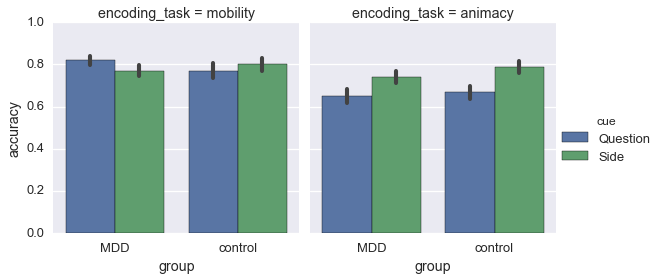

In [46]:
# I think this is a good way to plot the data b/c it highlights the gorup difference in the cue effect for words from
# the mobility task. 
sns.set_style('darkgrid')
sns.set_context('talk')
sns.factorplot(y='accuracy',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',data=noe,
              order = ['MDD','control'])
sns.plt.ylim(0,1,0.2)
sns.plt.savefig(path2figs + 'Ret_Acc_GxCxT.pdf')

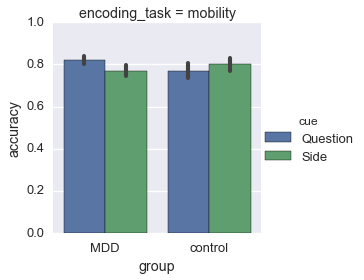

In [47]:
# Plotting the mobility data alone just to make it easier to line up with Q-S difference score plot
sns.set_style('darkgrid')
sns.set_context('talk')
sns.factorplot(y='accuracy',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',
               data=noe[noe.encoding_task == 'mobility'], order = ['MDD','control'])
sns.plt.ylim(0,1,0.2)
sns.plt.savefig(path2figs + 'Ret_Acc_GxC_MI.pdf')

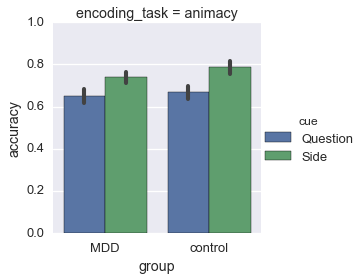

In [48]:
# Plotting the animacy data alone just to make it easier to line up with Q-S difference score plot
sns.factorplot(y='accuracy',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',
               data=noe[noe.encoding_task == 'animacy'], order = ['MDD','control'])
sns.plt.ylim(0,1.0,0.2)
sns.plt.savefig(path2figs + 'Ret_Acc_GxC_LNL.pdf')

In [49]:
# For guesses, response == 3 and accuracy == NaN. 
# We don't want to analyze those trials so let's drop.
# End up with effects of Cue and Task, plus Group x Cue and Cue x Task interactions. 
# Initially I followed up the interactions, but I think I would recommend going straight to the Group x Cue ANOVAs,
# separately by task. Or you could start with that--rather than Group x Cue x Task, you could do two Group x Cues.
# That might be too cheesy and it'd mean all the other ANOVAs would have to be done that way too . . . 

noe_nog = noe[~(noe.response == 3)]
%Rpush noe_nog
# %R str(noe)

%R ret_acc <- aov_ez(id='subject',dv='accuracy', within=c('cue','encoding_task'), between='group', data=noe_nog)
%R print(ret_acc)

Anova Table (Type 3 tests)

Response: accuracy
                   Effect    df  MSE         F  ges p.value
1                   group 1, 46 0.05      0.12 .002     .73
2                     cue 1, 46 0.01 17.47 ***  .03   .0001
3               group:cue 1, 46 0.01    6.42 *  .01     .01
4           encoding_task 1, 46 0.01 31.95 ***  .09  <.0001
5     group:encoding_task 1, 46 0.01      2.44 .007     .13
6       cue:encoding_task 1, 46 0.01 22.35 ***  .05  <.0001
7 group:cue:encoding_task 1, 46 0.01      0.84 .002     .36

Sphericity correction method: GG 


In [50]:
# BP Reviewer 1 asked if the results still hold when including IQ or Education as covariates. Let's see . . . 
# adding Education makes no difference, but with WTAR in there the Group x Cue is n.s., although WTAR x G x C is sig.
# This is fine but actually the Group x Cue for mobility trials is probably more important, let's check that too.

%R ret_acc_afex <- aov_ez(id='subject', dv='accuracy', data=noe_nog, between='group', within=c('cue','encoding_task'))

%R ret_acc_educ <- aov_ez(id='subject', dv='accuracy', data=noe_nog, between='group', within=c('cue','encoding_task'),\
                  covariate=c('Education_Years'))

noe_nog_wtar = noe_nog[noe_nog.WTAR_NatEng=='yes']
%Rpush noe_nog_wtar

%R ret_acc_wtar <- aov_ez(id='subject', dv='accuracy', data=noe_nog_wtar, between='group',\
                          within=c('cue','encoding_task'),covariate=c('WTAR_StdScore'))
                   
%R print(ret_acc_afex)
%R print(ret_acc_educ)
%R print(ret_acc_wtar)

/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Converting to factor: Education_Years

  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group, Education_Years

  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Converting to factor: WTAR_StdScore

  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group, WTAR_StdScore

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: accuracy
                   Effect    df  MSE         F  ges p.value
1                   group 1, 46 0.05      0.12 .002     .73
2                     cue 1, 46 0.01 17.47 ***  .03   .0001
3               group:cue 1, 46 0.01    6.42 *  .01     .01
4           encoding_task 1, 46 0.01 31.95 ***  .09  <.0001
5     group:encoding_task 1, 46 0.01      2.44 .007     .13
6       cue:encoding_task 1, 46 0.01 22.35 ***  .05  <.0001
7 group:cue:encoding_task 1, 46 0.01      0.84 .002     .36

Sphericity correction method: GG 


Anova Table (Type 3 tests)

Response: accuracy
                              Effect     df  MSE      F  ges p.value
1                              group  1, 36 0.04   0.08 .001     .78
2                    Education_Years 10, 36 0.04 2.09 +  .27     .05
3                                cue  1, 36 0.01 5.66 *  .02     .02
4                          group:cue  1, 36 0.01 4.42 *  .01     .04
5                Education_Years:cue 10, 36 0.01   0.43  .01     .92
6                      encoding_task  1, 36 0.01 6.61 *  .03     .01
7                group:encoding_task  1, 36 0.01 6.38 *  .02     .02
8      Education_Years:encoding_task 10, 36 0.01   1.48  .05     .19
9                  cue:encoding_task  1, 36 0.01 3.77 +  .01     .06
10           group:cue:encoding_task  1, 36 0.01 3.46 +  .01     .07
11 Education_Years:cue:encoding_task 10, 36 0.01   1.19  .04     .33

Sphericity correction method: GG 


Anova Table (Type 3 tests)

Response: accuracy
                            Effect     df  MSE         F    ges p.value
1                            group  1, 23 0.04      0.60    .02     .45
2                    WTAR_StdScore 19, 23 0.04      1.34    .43     .25
3                              cue  1, 23 0.01   7.99 **    .03    .010
4                        group:cue  1, 23 0.01      0.88   .004     .36
5                WTAR_StdScore:cue 19, 23 0.01      1.05    .08     .45
6                    encoding_task  1, 23 0.01 14.30 ***    .09   .0010
7              group:encoding_task  1, 23 0.01      0.00 <.0001    >.99
8      WTAR_StdScore:encoding_task 19, 23 0.01      1.10    .12     .41
9                cue:encoding_task  1, 23 0.01  13.61 **    .05    .001
10         group:cue:encoding_task  1, 23 0.01      1.30   .005     .27
11 WTAR_StdScore:cue:encoding_task 19, 23 0.01    2.08 *    .12     .05

Sphericity correction method: GG 


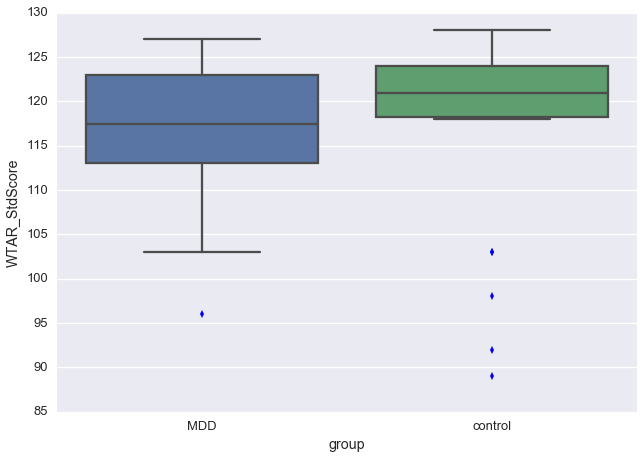

In [51]:
g = noe_nog_wtar.groupby(['group','subject'])['WTAR_StdScore'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()
sns.boxplot(y='WTAR_StdScore',x='group',data=df)

In [52]:
# To follow-up the Group x Cue, we can just run b/w group t-tests at each level of Cue.
# Neither one is significant, but looking at the t values you can see why there is an interaction: 
# it's MDD > HC under Question but MDD < HC under Side.

g = noe_nog.groupby(['subject','group','cue'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)

print 'Group difference under Question:'
misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Question')]['accuracy'],
              df[(df.group == 'MDD') & (df.cue == 'Question')]['accuracy'])
print '\nGroup difference under Side:'
misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Side')]['accuracy'],
              df[(df.group == 'MDD') & (df.cue == 'Side')]['accuracy'])

Group difference under Question:
t(46) = -0.57, p = 0.575

Group difference under Side:
t(46) = 1.19, p = 0.242


(1.1858011203853369, 0.24179010619890151)

In [53]:
# Here are the descriptives . . the group differences are pretty modest . . . 
print 100*(df.groupby(['group','cue'])['accuracy'].mean())
print '\n'
print 100*(df.groupby(['group','cue'])['accuracy'].std())

group    cue     
MDD      Question    73.882341
         Side        75.534648
control  Question    72.031600
         Side        79.471551
Name: accuracy, dtype: float64


group    cue     
MDD      Question     9.202547
         Side         9.841238
control  Question    13.136984
         Side        12.949650
Name: accuracy, dtype: float64


In [54]:
# To follow-up the Cue x Task, we can collapse over group and run b/w Task comparisons under each Cue.
# No surprise here, big Task effect (mobility > animacy) under Question but not Side . . .

g = noe_nog.groupby(['subject','cue','encoding_task'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

print 'Task difference under Question:'
misc.ttest_2s(df[(df.encoding_task == 'mobility') & (df.cue == 'Question')]['accuracy'],
              df[(df.encoding_task == 'animacy') & (df.cue == 'Question')]['accuracy'])
print '\nTask difference under Side:'
misc.ttest_2s(df[(df.encoding_task == 'mobility') & (df.cue == 'Side')]['accuracy'],
              df[(df.encoding_task == 'animacy') & (df.cue == 'Side')]['accuracy'])

Task difference under Question:
t(94) = 4.75, p = 0.000

Task difference under Side:
t(94) = 0.84, p = 0.402


(0.84211437083819451, 0.4018613871872595)

In [55]:
# The other way to follow-up the Cue x Task is to collapse over group and run b/w Cue comparisons for each Task.
# As with the second method of plotting the accuracy data, this is probably better b/c done this way you have the 
# Cue effect when the words/task are being held constant (cleaner look at the retrieval effects).

# And what you find is a big Cue effect for words from the animacy task, no effect at all for words from mobility.

g = noe_nog.groupby(['subject','cue','encoding_task'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

print 'Cue effect for words from the mobility task:'
misc.ttest_2s(df[(df.encoding_task == 'mobility') & (df.cue == 'Question')]['accuracy'],
              df[(df.encoding_task == 'mobility') & (df.cue == 'Side')]['accuracy'])
print '\nCue effect for words from the animacy task:'
misc.ttest_2s(df[(df.encoding_task == 'animacy') & (df.cue == 'Question')]['accuracy'],
              df[(df.encoding_task == 'animacy') & (df.cue == 'Side')]['accuracy'])

Cue effect for words from the mobility task:
t(94) = 0.38, p = 0.703

Cue effect for words from the animacy task:
t(94) = -3.95, p = 0.000


(-3.9457117875528387, 0.00015334692134536288)

Of course the stinker here is there is no 3-way interaction. What if you look for Group x Cue only under for words from mobility?

In [56]:
# If you look only at data from the mobility task, you get a strong Group x Cue interaction, F > 6.3, p = 0.01.
# No Cue effect here, F < 1.

noe_nog_MI = noe_nog[noe_nog.encoding_task == 'mobility']
%Rpush noe_nog_MI

%R ret_acc_MI <- aov_ez(id='subject',dv='accuracy', within='cue', between='group', data=noe_nog_MI)
%R print(ret_acc_MI)

Anova Table (Type 3 tests)

Response: accuracy
     Effect    df  MSE      F  ges p.value
1     group 1, 46 0.03   0.10 .002     .75
2       cue 1, 46 0.01   0.43 .002     .52
3 group:cue 1, 46 0.01 6.45 *  .02     .01

Sphericity correction method: GG 


In [57]:
# Make sure you don't get Group x Cue for animacy. No, F < 1; just a strong Cue effect (F > 35).
noe_nog_LNL = noe_nog[noe_nog.encoding_task == 'animacy']
%Rpush noe_nog_LNL

%R ret_acc_LNL <- aov_ez(id='subject',dv='accuracy', within='cue', between='group', data=noe_nog_LNL)
%R print(ret_acc_LNL)

Anova Table (Type 3 tests)

Response: accuracy
     Effect    df  MSE         F  ges p.value
1     group 1, 46 0.03      0.94  .02     .34
2       cue 1, 46 0.01 35.89 ***  .14  <.0001
3 group:cue 1, 46 0.01      1.00 .005     .32

Sphericity correction method: GG 


In [58]:
# Here are the descriptives. 14% difference b/w tasks under Question, 3% under Side.

print 100*(df.groupby(['cue','encoding_task'])['accuracy'].mean())
print '\n'
print 100*(df.groupby(['cue','encoding_task'])['accuracy'].std())

cue       encoding_task
Question  animacy          65.923338
          mobility         79.553235
Side      animacy          76.436967
          mobility         78.523520
Name: accuracy, dtype: float64


cue       encoding_task
Question  animacy          14.180475
          mobility         13.923627
Side      animacy          11.819947
          mobility         12.448846
Name: accuracy, dtype: float64


In [59]:
# Okay, now compute the Q-S difference scores for mobility
noe_nog_MI.head()
g = noe_nog_MI.groupby(['subject','group','cue'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
table_MI = df.pivot_table(index=['subject','group'],columns='cue',values='accuracy')
table_MI.reset_index(inplace=True)
new_cols = ['subject','group','Question','Side']
table_MI.columns = new_cols
table_MI['Q-S'] = table_MI['Question']-table_MI['Side']
table_MI['condition'] = 'mobility'
table_MI.head()

,subject,group,Question,Side,Q-S,condition
0,SM011,control,0.304348,0.434783,-0.130435,mobility
1,SM013,control,0.717391,0.700000,0.017391,mobility
2,SM014,control,0.744186,0.869565,-0.125379,mobility
3,SM015,MDD,0.765957,0.541667,0.224291,mobility
4,SM017,control,0.854167,0.860465,-0.006298,mobility


In [60]:
# Give me descriptives and the b/w groups t-test
print 100*(table_MI.groupby('group')['Q-S'].mean())
print 100*(table_MI.groupby('group')['Q-S'].std())
misc.ttest_2s(table_MI[table_MI.group == 'MDD']['Q-S'],
             table_MI[table_MI.group == 'control']['Q-S'])

group
MDD        5.025046
control   -2.965615
Name: Q-S, dtype: float64
group
MDD        11.949340
control     9.740642
Name: Q-S, dtype: float64
t(46) = 2.54, p = 0.015


(2.5392415907979102, 0.014554707420496868)

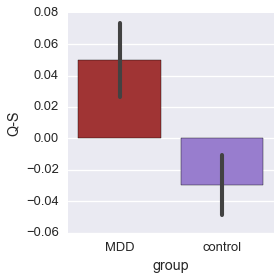

In [61]:
# And plot it . . . 
sns.factorplot(y='Q-S',x='group',units='subject',ci=68,kind='bar',data=table_MI,
              order = ['MDD','control'], palette = {'MDD':'FireBrick','control':'MediumPurple'})
sns.plt.ylim(-0.06,0.08,0.02)
sns.plt.savefig(path2figs + 'QvS_MI.pdf')

In [62]:
# Check: are either of these different from zero?
misc.ttest_1s(table_MI[table_MI.group == 'MDD']['Q-S'])
misc.ttest_1s(table_MI[table_MI.group == 'control']['Q-S'])

t(23) = 2.06, p = 0.051
t(23) = -1.49, p = 0.149


(-1.4915327432943173, 0.14941108363885475)

In [63]:
# Now compute the Q-S difference scores for animacy

g = noe_nog_LNL.groupby(['subject','group','cue'])['accuracy'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
table_LNL = df.pivot_table(index=['subject','group'],columns='cue',values='accuracy')
table_LNL.reset_index(inplace=True)
new_cols = ['subject','group','Question','Side']
table_LNL.columns = new_cols
table_LNL['Q-S'] = table_LNL['Question']-table_LNL['Side']
table_LNL['condition'] = 'animacy'
table_LNL.head()

,subject,group,Question,Side,Q-S,condition
0,SM011,control,0.702128,0.437500,0.264628,animacy
1,SM013,control,0.476190,0.790698,-0.314507,animacy
2,SM014,control,0.723404,0.941176,-0.217772,animacy
3,SM015,MDD,0.413043,0.541667,-0.128623,animacy
4,SM017,control,0.652174,0.780488,-0.128314,animacy


In [64]:
# Give me descriptives and the b/w groups t-test
print 100*(table_LNL.groupby('group')['Q-S'].mean())
print 100*(table_LNL.groupby('group')['Q-S'].std())
misc.ttest_2s(table_LNL[table_LNL.group == 'MDD']['Q-S'],
             table_LNL[table_LNL.group == 'control']['Q-S'])

group
MDD        -8.761376
control   -12.265881
Name: Q-S, dtype: float64
group
MDD         9.822191
control    14.113031
Name: Q-S, dtype: float64
t(46) = 1.00, p = 0.323


(0.99848401851382407, 0.32326834362609924)

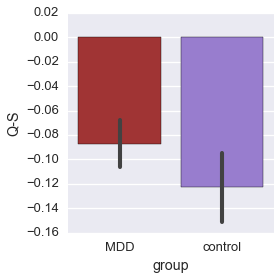

In [65]:
# And plot it . . . 
sns.factorplot(y='Q-S',x='group',units='subject',ci=68,kind='bar',data=table_LNL,
              order = ['MDD','control'],palette = {'MDD':'FireBrick','control':'MediumPurple'})
sns.plt.savefig(path2figs + 'QvS_LNL.pdf')

In [66]:
# Need to concat tables for w/in group t-tests
both = pd.concat([table_MI,table_LNL])
both.head()

print 'MDD . . . '
misc.ttest_2s(both[(both.group == 'MDD') & (both.condition == 'mobility')]['Q-S'],
             both[(both.group == 'MDD') & (both.condition == 'animacy')]['Q-S'],
             paired=True)

print 'controls . . . '
misc.ttest_2s(both[(both.group == 'control') & (both.condition == 'mobility')]['Q-S'],
             both[(both.group == 'control') & (both.condition == 'animacy')]['Q-S'],
             paired=True)

MDD . . . 
t(23) = 3.82, p = 0.001
controls . . . 
t(23) = 2.83, p = 0.010


(2.8283273839001555, 0.0095281927944516273)

In [67]:
both.head()

,subject,group,Question,Side,Q-S,condition
0,SM011,control,0.304348,0.434783,-0.130435,mobility
1,SM013,control,0.717391,0.700000,0.017391,mobility
2,SM014,control,0.744186,0.869565,-0.125379,mobility
3,SM015,MDD,0.765957,0.541667,0.224291,mobility
4,SM017,control,0.854167,0.860465,-0.006298,mobility


In [68]:
# R doesn't like 'Q-S', thinks it's Q minus S (which I suppose it is . . .)
both['Q_vs_S'] = both['Q-S']

In [69]:
# Compute Cohen's D for the follow-up t-tests on Q-S accuracy
%Rpush both
%R MDD_QSxTask.es <- cohen.d(Q_vs_S ~ condition, data=subset(both, group=='MDD'), paired=TRUE)
%R HC_QSxTask.es <- cohen.d(Q_vs_S ~ condition, data=subset(both, group=='control'), paired=TRUE)
%R MDD_vs_HC_QS_MI.es <- cohen.d(Q_vs_S ~ group, data=subset(both, condition=='mobility'), paired=FALSE)
%R MDD_vs_HC_QS_LNL.es <- cohen.d(Q_vs_S ~ group, data=subset(both, condition=='animacy'), paired=FALSE)

%R print(MDD_QSxTask.es)
%R print(HC_QSxTask.es)
%R print(MDD_vs_HC_QS_MI.es)
%R print(MDD_vs_HC_QS_LNL.es)


Cohen's d

d estimate: -0.779421 (medium)
95 percent confidence interval:
       inf        sup 
-1.3960602 -0.1627819 



Cohen's d

d estimate: -0.5773299 (medium)
95 percent confidence interval:
        inf         sup 
-1.18366597  0.02900615 



Cohen's d

d estimate: -0.7330159 (medium)
95 percent confidence interval:
       inf        sup 
-1.3470342 -0.1189976 



Cohen's d

d estimate: -0.2882375 (small)
95 percent confidence interval:
       inf        sup 
-0.8850155  0.3085405 


In [70]:
# Any chance you get a sig b/w group diff for Q/MI? Nope
misc.ttest_2s(both[(both.group == 'MDD') & (both.condition == 'mobility')]['Question'],
             both[(both.group == 'control') & (both.condition == 'mobility')]['Question'])

t(46) = 1.28, p = 0.207


(1.2792348461266727, 0.20722975813559297)

In [71]:
# In response to BP Reviewer 1, let's repeat the Group x Cue under mobility with education and WTAR as covs to see
# if they matter. Education does not matter but WTAR is significant and there is a Cue x WTAR interaction that
# renders the Group x Cue effect n.s.

noe_nog_MI_wtar = noe_nog_MI[noe_nog_MI.WTAR_NatEng == 'yes']
%Rpush noe_nog_MI_wtar

%R ret_acc_MI_afex <- aov_ez(id='subject', dv='accuracy', data=noe_nog_MI, between='group', within='cue')

%R ret_acc_MI_educ <- aov_ez(id='subject', dv='accuracy', data=noe_nog_MI, between='group',\
                             within='cue', covariate=c('Education_Years'))

%R ret_acc_MI_wtar <- aov_ez(id='subject', dv='accuracy', data=noe_nog_MI_wtar, between='group',\
                             within='cue',covariate=c('WTAR_StdScore'))

%R print(ret_acc_MI_afex)
%R print(ret_acc_MI_educ)
%R print(ret_acc_MI_wtar)

Anova Table (Type 3 tests)

Response: accuracy
     Effect    df  MSE      F  ges p.value
1     group 1, 46 0.03   0.10 .002     .75
2       cue 1, 46 0.01   0.43 .002     .52
3 group:cue 1, 46 0.01 6.45 *  .02     .01

Sphericity correction method: GG 


Anova Table (Type 3 tests)

Response: accuracy
               Effect     df  MSE       F   ges p.value
1               group  1, 36 0.02    1.66   .04     .21
2     Education_Years 10, 36 0.02  1.84 +   .29     .09
3                 cue  1, 36 0.01    0.12 .0007     .74
4           group:cue  1, 36 0.01 8.39 **   .05    .006
5 Education_Years:cue 10, 36 0.01    0.59   .03     .81

Sphericity correction method: GG 


Anova Table (Type 3 tests)

Response: accuracy
             Effect     df  MSE      F    ges p.value
1             group  1, 23 0.02   0.66    .02     .43
2     WTAR_StdScore 19, 23 0.02 2.32 *    .62     .03
3               cue  1, 23 0.00   0.28   .002     .60
4         group:cue  1, 23 0.00   0.01 <.0001     .92
5 WTAR_StdScore:cue 19, 23 0.00 2.79 *    .26     .01

Sphericity correction method: GG 


In [72]:
noe_nog_MI_wtar.WTAR_StdScore.describe()

count    3792.000000
mean      116.829905
std         9.784776
min        89.000000
25%       113.000000
50%       120.000000
75%       124.000000
max       128.000000
Name: WTAR_StdScore, dtype: float64

In [73]:
def MedSplit(wtar):
    '''Based on the descriptive data, I am running a median split on WTAR scores to ease the graphing.'''
    if wtar < 120:
        out = 'low'
    elif wtar > 120:
        out = 'high'
    elif wtar == 120:
        out = np.nan
        
    return out

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


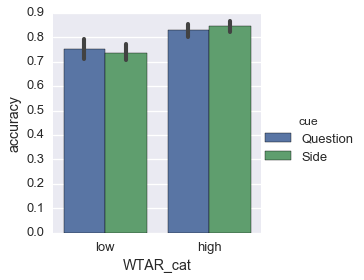

In [74]:

noe_nog_MI_wtar['WTAR_cat'] = noe_nog_MI_wtar.WTAR_StdScore.apply(MedSplit)
# g = sns.factorplot(y='accuracy',x='WTAR_StdScore',hue='cue',ci=68,kind='bar',data=noe_nog_MI_wtar)
# g.set_xticklabels(rotation=90)
sns.factorplot(y='accuracy',x='WTAR_cat',hue='cue',units='subject',ci=68,kind='bar',data=noe_nog_MI_wtar)

In [75]:
table_MI.head()

,subject,group,Question,Side,Q-S,condition
0,SM011,control,0.304348,0.434783,-0.130435,mobility
1,SM013,control,0.717391,0.700000,0.017391,mobility
2,SM014,control,0.744186,0.869565,-0.125379,mobility
3,SM015,MDD,0.765957,0.541667,0.224291,mobility
4,SM017,control,0.854167,0.860465,-0.006298,mobility


In [76]:
wtar_native = []
wtar_StdScore = []
for i, row_i in table_MI.iterrows():
    wtar_native.append(noe_nog[noe_nog.subject == row_i.subject].WTAR_NatEng.unique()[0])
    wtar_StdScore.append(noe_nog[noe_nog.subject == row_i.subject].WTAR_StdScore.unique()[0])
table_MI['WTAR_NatEng'] = wtar_native
table_MI['WTAR_StdScore'] = wtar_StdScore
table_MI_wtar = table_MI[table_MI.WTAR_NatEng == 'yes']
table_MI_wtar.sort_values('WTAR_StdScore',inplace=True)

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


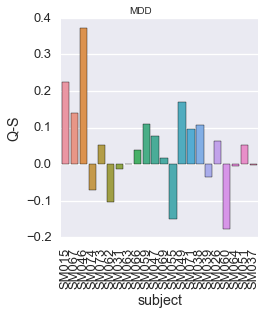

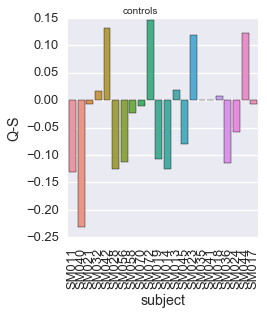

In [77]:
g = sns.factorplot(y='Q-S',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'MDD'],kind='bar')
g.set_xticklabels(rotation=90)
plt.suptitle('MDD')

g = sns.factorplot(y='Q-S',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'control'],kind='bar')
g.set_xticklabels(rotation=90)
plt.suptitle('controls')

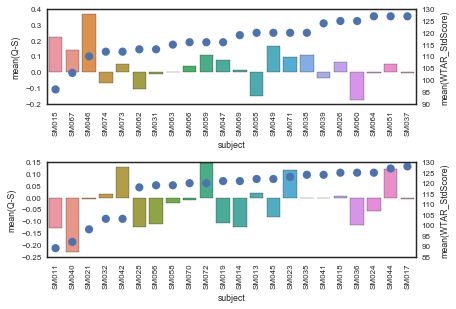

In [78]:
sns.set_style('white')
sns.set_context('paper')

fig = plt.figure()
ax1 = fig.add_subplot(211)
g = sns.barplot(y='Q-S',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'MDD'],ax=ax1)
g.set_xticklabels(table_MI_wtar[table_MI_wtar.group == 'MDD']['subject'],rotation=90)
h = sns.pointplot(y='WTAR_StdScore',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'MDD'],\
                  join=False,ax=ax1.twinx())

ax2 = fig.add_subplot(212)
g = sns.barplot(y='Q-S',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'control'],ax=ax2)
g.set_xticklabels(table_MI_wtar[table_MI_wtar.group == 'control']['subject'],rotation=90)
h = sns.pointplot(y='WTAR_StdScore',x='subject',data=table_MI_wtar[table_MI_wtar.group == 'control'],\
                  join=False,ax=ax2.twinx())

fig.tight_layout()

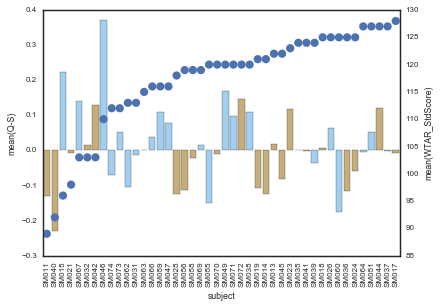

In [79]:
sns.set_style('white')
sns.set_context('paper')

pal_dict = {'control':sns.xkcd_rgb['tan'],'MDD':sns.xkcd_rgb['light blue']}
fig = plt.figure()
ax1 = fig.add_subplot(111)
g = sns.barplot(y='Q-S',x='subject',palette = table_MI_wtar['group'].map(pal_dict),data=table_MI_wtar,ax=ax1)
g.set_xticklabels(table_MI_wtar['subject'],rotation=90)
h = sns.pointplot(y='WTAR_StdScore',x='subject',data=table_MI_wtar,join=False,ax=ax1.twinx())
plt.savefig(path2figs + 'Q-S_by_WTAR.pdf')

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


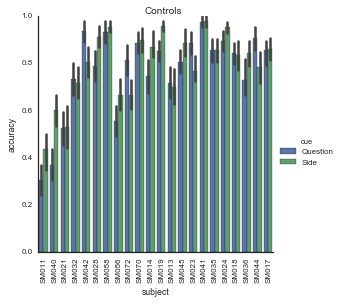

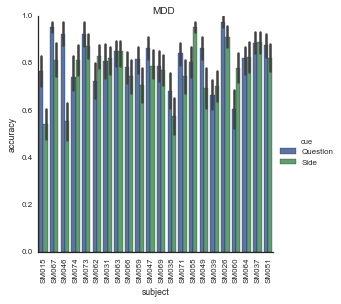

In [80]:
noe_nog_MI_wtar_hc = noe_nog_MI_wtar[noe_nog_MI_wtar.group == 'control']
noe_nog_MI_wtar_hc.sort_values('WTAR_StdScore',inplace=True)

noe_nog_MI_wtar_mdd = noe_nog_MI_wtar[noe_nog_MI_wtar.group == 'MDD']
noe_nog_MI_wtar_mdd.sort_values('WTAR_StdScore',inplace=True)

g = sns.factorplot(y='accuracy',x='subject',hue='cue',ci=68,kind='bar',data=noe_nog_MI_wtar_hc,
                  hue_order=['Question','Side'])
g.set_xticklabels(rotation=90)
plt.suptitle('Controls')

g = sns.factorplot(y='accuracy',x='subject',hue='cue',ci=68,kind='bar',data=noe_nog_MI_wtar_mdd,
                  hue_order=['Question','Side'])
g.set_xticklabels(rotation=90)
plt.suptitle('MDD')

Okay, so the **bottom line** here is we have a Group x Cue effect for words from the mobility task but not the animacy task. For words from both tasks, we isolate the Cue effect by performing Q-S subtractions. For words from the mobility task, that difference score is more positive in MDD vs. HC, but for words from the animacy task, there is no group difference. This indicates that the MDD group was more affected by the cueing manipulation than the HC group for words from the mobility task, with the Qcue supporting the highest level of accuracy in MDD (when paired with words from the mobility task). This is in line with the idea that MDDs do best with deep encoding followed by conceptual retrieval (may be worth re-reading Ed Watkins's work on conceptual implicit retrieval in MDD).

### Correct RT 

#### Odd/Even 

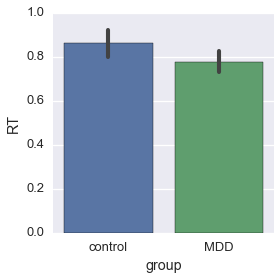

In [81]:
# Shows that on Odd/Even trials, the MDDs are actually a bit faster than the controls. No psychomotor slowing here!
sns.set_style('darkgrid')
sns.set_context('talk')
oe_corr = oe[oe.accuracy == 1]
sns.factorplot(y='RT',x='group',units='subject',ci=68,kind='bar',data=oe_corr)

In [82]:
# Drop the 2 subs with no RT data, then run a t-test on the group difference in correct RT on Odd/Even trials.
# No difference. 

oe_corr_clean = oe_corr[~((oe_corr.subject == 'SM045') | (oe_corr.subject == 'SM046'))]
g = oe_corr_clean.groupby(['group','subject'])['RT'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()
print 1000*(df.groupby('group')['RT'].mean())
print 1000*(df.groupby('group')['RT'].std())
misc.ttest_2s(df[df.group == 'control']['RT'],df[df.group == 'MDD']['RT'])

group
MDD        777.21508
control    859.86735
Name: RT, dtype: float64
group
MDD        225.646971
control    299.182814
Name: RT, dtype: float64
t(44) = 1.06, p = 0.296


(1.0577755563355071, 0.29593071997468423)

#### Group x Cue x Task 

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


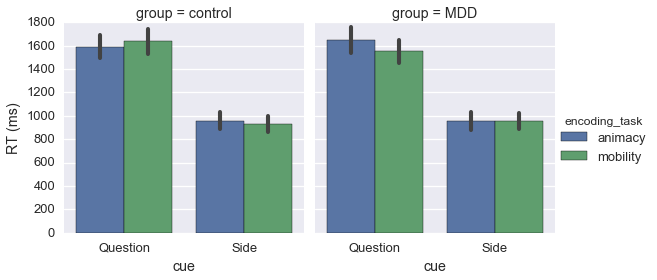

In [83]:
# Strong effect of Cue, no big effects of Group or Task, maybe a Group x Cue x Task . . . 
noe_nog_corr = noe_nog[noe_nog.accuracy == 1]
noe_nog_corr['RT (ms)'] = noe_nog_corr['RT'].apply(lambda x: 1000*x)
sns.factorplot(y='RT (ms)',x='cue',hue='encoding_task',col='group',units='subject',ci=68,kind='bar',data=noe_nog_corr)

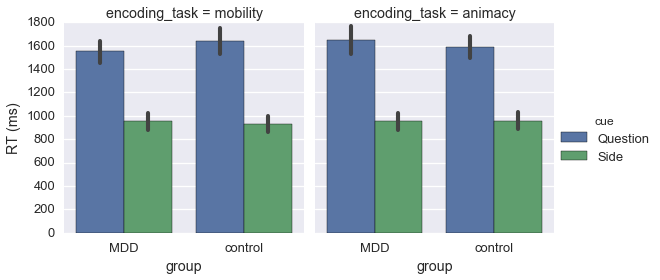

In [84]:
sns.factorplot(y='RT (ms)',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',data=noe_nog_corr,
              order = ['MDD','control'],col_order=['mobility','animacy'])
sns.plt.savefig(path2figs + 'Ret_RT_GxCxT_new.pdf')

In [85]:
# First drop the two subs with no RT data, then run the ANOVA . . . and the only sig effect is the huge Cue effect.

noe_nog_corr_clean = noe_nog_corr[~((noe_nog_corr.subject == 'SM045') | (noe_nog_corr.subject == 'SM046'))]
%Rpush noe_nog_corr_clean
# %R str(noe_nog_corr_clean)

%R ret_rt <- aov_ez(id='subject', dv='RT', within=c('cue','encoding_task'), between='group', data=noe_nog_corr_clean)
%R print(ret_rt)

Anova Table (Type 3 tests)

Response: RT
                   Effect    df  MSE          F    ges p.value
1                   group 1, 44 0.62       0.01  .0001     .94
2                     cue 1, 44 0.10 194.99 ***    .37  <.0001
3               group:cue 1, 44 0.10       0.02 <.0001     .89
4           encoding_task 1, 44 0.02     2.91 +   .002     .10
5     group:encoding_task 1, 44 0.02       1.43  .0009     .24
6       cue:encoding_task 1, 44 0.02       0.58  .0004     .45
7 group:cue:encoding_task 1, 44 0.02     2.88 +   .002     .10

Sphericity correction method: GG 


In [86]:
# Here are the descriptives on the Cue effect (RT in ms)
g = noe_nog_corr_clean.groupby(['subject','group','cue','encoding_task'])['RT'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
print 1000*(df.groupby('cue')['RT'].mean())
print 1000*(df.groupby('cue')['RT'].std())

%Rpush df
%R ret_RT_cue.es <- cohen.d(RT ~ cue, data=df)
%R print(ret_RT_cue.es)

cue
Question    1619.105743
Side         958.978519
Name: RT, dtype: float64
cue
Question    519.317905
Side        322.706800
Name: RT, dtype: float64



Cohen's d

d estimate: 1.526881 (large)
95 percent confidence interval:
     inf      sup 
1.194059 1.859702 


So the **bottom line** with respect to correct RT is that there is only one strong effect: everyone is slower in response to the Question cue vs. the Side cue.

### Confidence 

Confidence is coded as "high" or "low", which isn't super helpful for ANOVAs, so let's re-express that as the percentage of high confidence responses . . . . 

In [87]:
oe['high_confidence'] = oe.confidence.apply(lambda x: 1 if x == 'high' else 0)
noe_nog['high_confidence'] = noe_nog.confidence.apply(lambda x: 1 if x == 'high' else 0)

/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/danieldillon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


#### Odd/Even 

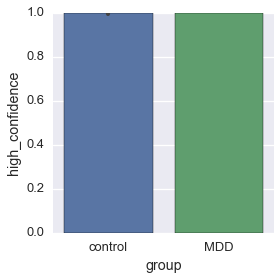

In [88]:
# Shows that eveybody is super confidence on Odd/Even trials.
sns.factorplot(y='high_confidence',x='group',units='subject',ci=68,kind='bar',data=oe)

In [89]:
g = oe.groupby(['subject','group'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()
print 100*(df.groupby('group')['high_confidence'].mean())
print 100*(df.groupby('group')['high_confidence'].std())
misc.ttest_2s(df[df.group == 'control']['high_confidence'],df[df.group == 'MDD']['high_confidence'])

group
MDD        99.869792
control    99.694810
Name: high_confidence, dtype: float64
group
MDD        0.351908
control    0.653259
Name: high_confidence, dtype: float64
t(46) = -1.16, p = 0.254


(-1.155274634980042, 0.2539438198883528)

#### Group x Cue x Task 

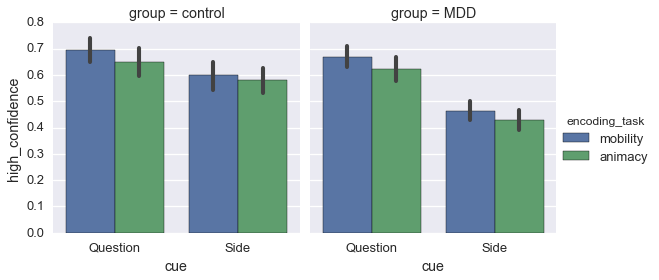

In [90]:
# So I'm seeing main effects of Cue (Q > S), Task (mobility > animacy, and probably a Group x Cue interaction
# because there appears to be HC > MDD under Side but not Cue
sns.factorplot(y='high_confidence',x='cue',hue='encoding_task',col='group',units='subject',ci=68,kind='bar',
               data=noe_nog)

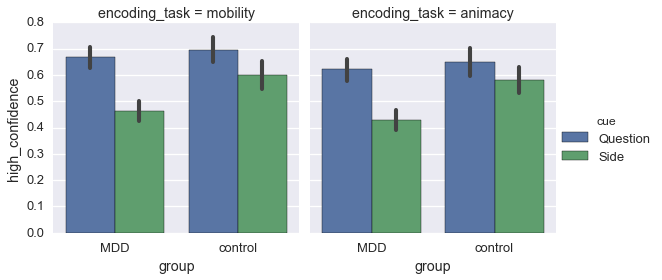

In [91]:
sns.factorplot(y='high_confidence',x='group',hue='cue',col='encoding_task',units='subject',ci=68,kind='bar',
               data=noe_nog,order = ['MDD','control'],col_order=['mobility','animacy'])
sns.plt.savefig(path2figs + 'Ret_Conf_GxCxT_new.pdf')

In [92]:
# Let's get some descriptives
g = noe_nog.groupby(['subject','group','cue','encoding_task'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
# df.head()
print 100*(df.groupby(['group','cue','encoding_task'])['high_confidence'].mean())
print '\n'
print 100*(df.groupby(['group','cue','encoding_task'])['high_confidence'].std())

group    cue       encoding_task
MDD      Question  animacy          61.993910
                   mobility         65.848451
         Side      animacy          42.425926
                   mobility         45.459879
control  Question  animacy          63.620718
                   mobility         68.580769
         Side      animacy          56.596250
                   mobility         58.848322
Name: high_confidence, dtype: float64


group    cue       encoding_task
MDD      Question  animacy          20.082089
                   mobility         19.036603
         Side      animacy          18.558922
                   mobility         17.907900
control  Question  animacy          26.318211
                   mobility         23.254590
         Side      animacy          24.170202
                   mobility         25.825928
Name: high_confidence, dtype: float64


In [93]:
# Yup, main effects of Cue and Task plus a Group x Cue interaction

%Rpush noe_nog
# %R str(noe_nog)

%R ret_conf <- aov_ez(id='subject',dv='high_confidence', within=c('cue','encoding_task'), between='group', data=noe_nog)
%R print(ret_conf)

Anova Table (Type 3 tests)

Response: high_confidence
                   Effect    df  MSE         F    ges p.value
1                   group 1, 46 0.15      2.10    .03     .15
2                     cue 1, 46 0.04 26.10 ***    .10  <.0001
3               group:cue 1, 46 0.04    4.37 *    .02     .04
4           encoding_task 1, 46 0.01    6.72 *   .007     .01
5     group:encoding_task 1, 46 0.01      0.00 <.0001     .95
6       cue:encoding_task 1, 46 0.00      0.83  .0004     .37
7 group:cue:encoding_task 1, 46 0.00      0.24  .0001     .63

Sphericity correction method: GG 


In [94]:
# First follow-up the main effect of task
g = noe_nog.groupby(['subject','group','encoding_task'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

misc.ttest_2s(df[df.encoding_task == 'mobility']['high_confidence'],
              df[df.encoding_task == 'animacy']['high_confidence'],
              paired=True)

%Rpush df
%R conf_task.es <- cohen.d(high_confidence ~ encoding_task, data=df, paired=TRUE)
%R print(conf_task.es)

t(47) = 2.75, p = 0.008



Cohen's d

d estimate: -0.1275564 (negligible)
95 percent confidence interval:
       inf        sup 
-0.5375637  0.2824510 


In [95]:
# Okay, so let's just run b/w group t-tests on % high confidence responses at each level of cue
g = noe_nog.groupby(['subject','group','cue'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

# Question: no difference
misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Question')]['high_confidence'],
              df[(df.group == 'MDD') & (df.cue == 'Question')]['high_confidence'], paired=False)

# Side: group difference, HC > MDD
misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Side')]['high_confidence'],
              df[(df.group == 'MDD') & (df.cue == 'Side')]['high_confidence'], paired=False)

%Rpush df
%R conf_GxC.es <- cohen.d(high_confidence ~ group, data=subset(df, cue=='Side'), paired=FALSE)
%R print(conf_GxC.es)

t(46) = 0.36, p = 0.721
t(46) = 2.25, p = 0.029



Cohen's d

d estimate: 0.6508021 (medium)
95 percent confidence interval:
       inf        sup 
0.04105616 1.26054810 


In [96]:
# Let's see if the Question > Side effect on confidence is there for both encoding tasks considered separately in MDD.
# I think so and want to highlight this as it contrasts with what we see for guesses and accuracy (and this suggests
# to me that the ERP effect we see over left parietal is tracking those and not confidence)

g = noe_nog.groupby(['subject','group','cue','encoding_task'])['high_confidence'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

misc.ttest_2s(df[(df.group == 'MDD') & (df.encoding_task == 'animacy') & (df.cue == 'Question')]['high_confidence'],
              df[(df.group == 'MDD') & (df.encoding_task == 'animacy') & (df.cue == 'Side')]['high_confidence'],
              paired=True)

misc.ttest_2s(df[(df.group == 'MDD') & (df.encoding_task == 'mobility') & (df.cue == 'Question')]['high_confidence'],
              df[(df.group == 'MDD') & (df.encoding_task == 'mobility') & (df.cue == 'Side')]['high_confidence'],
              paired=True)

%Rpush df
%R mdd_cue_conf_LNL.es <- cohen.d(high_confidence ~ cue, data=subset(df, group=='MDD' & encoding_task=='animacy'))
%R print(mdd_cue_conf_LNL.es)

%R mdd_cue_conf_MI.es <- cohen.d(high_confidence ~ cue, data=subset(df, group=='MDD' & encoding_task=='mobility'))
%R print(mdd_cue_conf_MI.es)

t(23) = 4.35, p = 0.000
t(23) = 5.46, p = 0.000



Cohen's d

d estimate: 1.012023 (large)
95 percent confidence interval:
      inf       sup 
0.3800475 1.6439988 



Cohen's d

d estimate: 1.103226 (large)
95 percent confidence interval:
      inf       sup 
0.4642744 1.7421771 


So the **bottom line** with respect to confidence is that everybody is more confident in response to the Question vs. the Side cue and in response to words from the mobility vs. the animacy task, and the depressed group was less confident than the control group under the Side cue.

### Confidence and Accuracy

In [97]:
g = noe.groupby(['subject','group','cue','encoding_task','confidence'])['accuracy'].mean()
c_a = g.to_frame()
c_a.reset_index(inplace=True)
c_a.head()

,subject,group,cue,encoding_task,confidence,accuracy
0,SM011,control,Question,animacy,high,0.702128
1,SM011,control,Question,mobility,high,0.318182
2,SM011,control,Question,mobility,low,0.000000
3,SM011,control,Question,mobility,nan,NaN
4,SM011,control,Side,animacy,high,0.448276


## ERPs 

Let's try the same Group x Cue x Task approach with the ANOVAs, relying on the MUT. The challenge with that is that's it not possible to simply run the ANOVA in one-step, so we will need to do it in a more piecemeal fashion. Here's how: (1) in controls, compute a "mobility - animacy" difference wave under the Question cue (so Q:M-A), repeat that under the Side cue (so S:M-A), and the compute a difference of differences (so Q:M-A minus S:M-A); (2) repeat all that in the MDD group; and (3) do Controls vs. MDD for Q:M-A minus S:M-A. That is the equivalent of the full 2 x 2 x 2 ANOVA. If we find significant group differences, we can look at the waveforms in electrodes that show the difference.

In [98]:
%cd {path2erps}

/Users/danieldillon/Work/Expts/SOURCE/Analysis/ERPs


In [99]:
#clean up csv files, adding in columns for cue, task, and laterality

def elec2laterality(electrode):
       
    left = [48,49,43,56,44,38,57,63,128,39,45,50,32,33,40,46,58,64,68,34,51,35,41,47,25,26,27,59,65,28,52,36,69,
           42,23,29,73,24,53,22,60,66,21,20,30,37,70,127,18,19,13,31,54,61,67,74,71,12,7]
    right = [5,106,126,10,4,112,80,79,78,77,76,82,14,118,105,87,83,9,86,85,84,88,3,124,111,104,93,89,117,92,8,2,
             123,98,91,90,110,103,116,97,1,122,109,102,96,95,94,115,108,101,125,121,114,100,99,120,113,107,119]
    midline = [17,15,16,11,6,55,62,72,75,81]
    
    if electrode in left:
        laterality = 'left'
    elif electrode in right:
        laterality = 'right'
    elif electrode in midline:
        laterality = 'midline'

    return laterality

def condition2task(condition):
    
    animacy = [97,111]
    mobility = [104,118]
    
    if condition in animacy:
        task = 'animacy'
    elif condition in mobility:
        task = 'mobility'

    return task

def condition2cue(condition):
    
    side = [97,104]
    question = [111,118]
    
    if condition in side:
        cue = 'Side'
    elif condition in question:
        cue = 'Question'

    return cue
    
def make_clean_df(csv):
    '''Read in a mean amps CSV and return a cleaned up df.'''
    df = pd.read_csv(csv,sep="\t",skipinitialspace=True)
    new_cols = ['time','uV','electrode','electrode_label','condition','subject']
    df.columns = new_cols
    df.electrode_label.replace({'E60':'P1','E52':'P3','E51':'P5',
                                'E58':'P7','E85':'P2','E92':'P4','E97':'P6',
                                'E96':'P8','E26':'AF7','E19':'F1',
                                'E24':'F3','E27':'F5','E33':'F7',
                               'E2':'AF8','E4':'F2','E124':'F4',
                                'E123':'F6','E122':'F8',
                               'E67':'PO3','E70':'O1','E62':'Pz',
                                'E72':'POz','E75':'Oz','E77':'PO4','E83':'O2'},
                               inplace=True)    
    df.subject = df.subject.map(lambda x: x.strip('_ERPs'))
    df['laterality'] = df.electrode.map(lambda x: elec2laterality(x))
    df['task'] = df.condition.map(lambda x: condition2task(x))
    df['cue'] = df.condition.map(lambda x: condition2cue(x))
    df = df[['subject','time','condition','cue','task','laterality',
             'electrode','electrode_label','uV']]
    df.condition.replace({97:'animacy side hit', 104:'mobility side hit', 
                          111:'animacy question hit',
                          118:'mobility question hit'},inplace=True)
    
    return df

### The following analyses are based on the traditional 4 left (P3, P5, P7, P1) and 4 right (P4, P6, P8, P2) electrodes

In [100]:
hc_par = make_clean_df(path2erps + 'MeanAmps/HC/HC_EncTask_RetCue_Parietal_400_800.txt')
mdd_par = make_clean_df(path2erps + 'MeanAmps/MDD/MDD_EncTask_RetCue_Parietal_400_800.txt')
hc_par['group'] = 'control'
mdd_par['group'] = 'MDD'
all_par = pd.concat([hc_par,mdd_par])
all_par.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
0,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,51,P5,-0.992,control
1,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,52,P3,1.481,control
2,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,58,P7,-0.048,control
3,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,60,P1,-1.063,control
4,SM011,[400.0 800.0],animacy side hit,Side,animacy,right,85,P2,-0.861,control


In [101]:
all_par.electrode_label.unique()

array(['P5', 'P3', 'P7', 'P1', 'P2', 'P4', 'P8', 'P6'], dtype=object)

In [102]:
all_par.groupby('group')['subject'].nunique()

group
MDD        24
control    24
Name: subject, dtype: int64

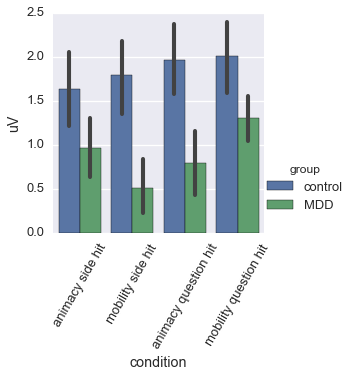

In [103]:
f = sns.factorplot(y = 'uV', x = 'condition',hue='group',kind='bar',units='subject',ci=68,
                   data=all_par)
f.set_xticklabels(rotation=60)

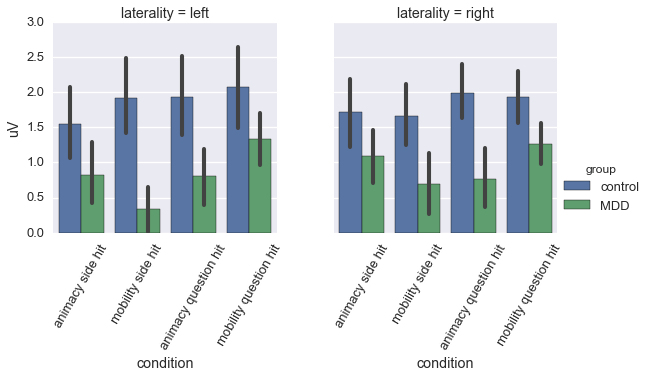

In [104]:
f = sns.factorplot(y = 'uV', x = 'condition',hue='group',col='laterality',kind='bar',units='subject',ci=68,
                   data=all_par)
f.set_xticklabels(rotation=60)

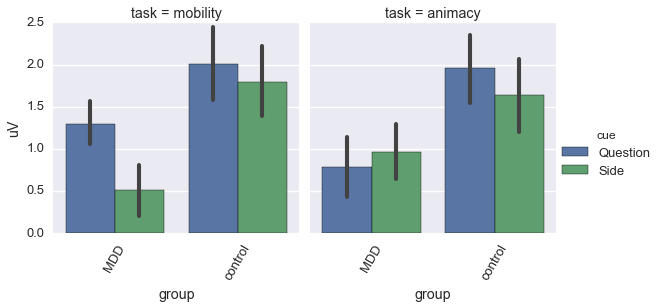

In [105]:
f = sns.factorplot(y = 'uV', x = 'group',hue='cue',col='task',kind='bar',units='subject',ci=68,
                   data=all_par, order =['MDD','control'],col_order=['mobility','animacy'],hue_order=['Question','Side'])
f.set_xticklabels(rotation=60)
sns.plt.savefig(path2figs + 'Par_uV_GxCxT.pdf')

In [106]:
#significant effect of group and cue, but not for GroupxCuexTask (though trending in the direction)

%Rpush all_par

%R erp_par <- ezANOVA(dv=uV, wid=subject, within=.(cue,task,laterality), between=group, data=all_par)
%R print(erp_par)

/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/danieldillon/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning:  Collapsing data to cell means. *IF* the requested effects are a subset of the full design, you must use the "within_full" argument, else results may be inaccurate.

  warnings.warn(x, RRuntimeWarning)


$ANOVA
                      Effect DFn DFd           F          p p<.05          ges
2                      group   1  46  4.48335496 0.03966354     * 5.293110e-02
3                        cue   1  46 10.34378385 0.00237944     * 5.040041e-03
5                       task   1  46  0.37900348 0.54117126       2.651048e-04
7                 laterality   1  46  0.02152881 0.88398868       1.214792e-04
4                  group:cue   1  46  0.03700366 0.84830432       1.812116e-05
6                 group:task   1  46  0.10860080 0.74323871       7.597829e-05
8           group:laterality   1  46  0.08108244 0.77711390       4.573648e-04
9                   cue:task   1  46  1.95804988 0.16842945       2.697534e-03
11            cue:laterality   1  46  1.41796608 0.23984712       5.016650e-04
13           task:laterality   1  46  0.79427935 0.37744735       2.920873e-04
10            group:cue:task   1  46  3.17517741 0.08136696       4.367004e-03
12      group:cue:laterality   1  46  1.40922

In [107]:
g = all_par.groupby(['subject','group','condition'])['uV'].mean()

df2=pd.DataFrame(g)
df2.reset_index(inplace=True)

df2.head()

,subject,group,condition,uV
0,SM011,control,animacy question hit,1.505500
1,SM011,control,animacy side hit,-0.317625
2,SM011,control,mobility question hit,1.684625
3,SM011,control,mobility side hit,0.959875
4,SM013,control,animacy question hit,1.938375


In [108]:
df3 = df2.pivot_table(index=['subject','group'], columns='condition', values='uV')
df3.reset_index(drop=False,inplace=True)
df3.columns = ['subject','group','animacy question','animacy side','mobility question','mobility side']
df3.head()

,subject,group,animacy question,animacy side,mobility question,mobility side
0,SM011,control,1.505500,-0.317625,1.684625,0.959875
1,SM013,control,1.938375,1.436750,3.152250,1.768750
2,SM014,control,-0.235000,-1.564125,-1.428875,-0.442625
3,SM015,MDD,1.306375,0.613625,1.887500,1.378250
4,SM017,control,3.690625,4.321750,4.313875,4.182875


In [109]:
df3['animacy q-s'] = df3['animacy question']-df3['animacy side']
df3['mobility q-s'] = df3['mobility question']-df3['mobility side']

In [110]:
df3.head()

,subject,group,animacy question,animacy side,mobility question,mobility side,animacy q-s,mobility q-s
0,SM011,control,1.505500,-0.317625,1.684625,0.959875,1.823125,0.72475
1,SM013,control,1.938375,1.436750,3.152250,1.768750,0.501625,1.38350
2,SM014,control,-0.235000,-1.564125,-1.428875,-0.442625,1.329125,-0.98625
3,SM015,MDD,1.306375,0.613625,1.887500,1.378250,0.692750,0.50925
4,SM017,control,3.690625,4.321750,4.313875,4.182875,-0.631125,0.13100


In [111]:
animacy_diff = df3[['subject', 'group', 'animacy q-s']].copy()
animacy_diff['task'] = 'animacy'
animacy_diff.columns = ['subject','group','value','task']

mobility_diff=df3[['subject','group','mobility q-s']].copy()
mobility_diff['task'] = 'mobility'
mobility_diff.columns = ['subject','group','value','task']

In [112]:
# Question-Side by task
g = pd.concat([mobility_diff,animacy_diff])
df4 = pd.DataFrame(g)
df4.head()

,subject,group,value,task
0,SM011,control,0.72475,mobility
1,SM013,control,1.38350,mobility
2,SM014,control,-0.98625,mobility
3,SM015,MDD,0.50925,mobility
4,SM017,control,0.13100,mobility


In [113]:
%Rpush df4

%R uv_par <- ezANOVA(dv=value, wid=subject, within=task, between=group, data=df4)
%R print (uv_par)

$ANOVA
      Effect DFn DFd          F          p p<.05          ges
2      group   1  46 0.03700366 0.84830432       0.0002104965
3       task   1  46 1.95804988 0.16842945       0.0304680535
4 group:task   1  46 3.17517741 0.08136696       0.0484887256



In [114]:
misc.ttest_2s(df4[(df4.group == 'control') & (df4.task == 'mobility')]['value'],
             df4[(df4.group == 'MDD') & (df4.task == 'mobility')]['value'], paired=False)

misc.ttest_2s(df4[(df4.group == 'control') & (df4.task == 'animacy')]['value'],
             df4[(df4.group == 'MDD') & (df4.task == 'animacy')]['value'],paired = False)

misc.ttest_2s(df4[(df4.group == 'control') & (df4.task == 'mobility')]['value'],
             df4[(df4.group == 'control') & (df4.task == 'animacy')]['value'], paired = True)

misc.ttest_2s(df4[(df4.group == 'MDD') & (df4.task == 'mobility')]['value'],
             df4[(df4.group == 'MDD') & (df4.task == 'animacy')]['value'], paired = True)

t(46) = -1.70, p = 0.096
t(46) = 1.38, p = 0.175
t(23) = -0.32, p = 0.749
t(23) = 1.97, p = 0.061


(1.9711360791482013, 0.060857240700011667)

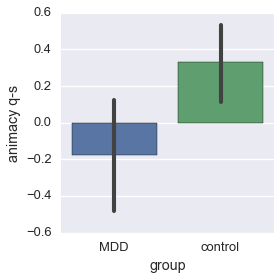

In [115]:
sns.factorplot(y='animacy q-s',x='group',units='subject',ci=68,kind='bar',data=df3, order =['MDD','control'])
sns.plt.savefig(path2figs + 'Par_uV_animacy_diff.pdf')

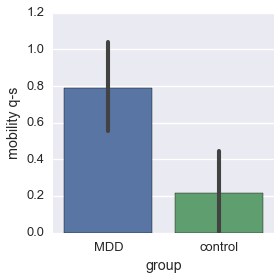

In [116]:
sns.factorplot(y='mobility q-s',x='group',units='subject',ci=68,kind='bar',data=df3, order = ['MDD','control'])
sns.plt.savefig(path2figs + 'Par_uV_mobility_diff.pdf')

In [117]:
g = all_par.groupby(['subject','group','cue','task'])['uV'].mean()
df5=pd.DataFrame(g)
df5.reset_index(inplace=True)

In [118]:
#New table for mobility accuracy
MI_acc = table_MI[['subject', 'group', 'Question','Side','Q-S']].copy()

MI_acc.columns = ['subject','group','mobility question acc','mobility side acc','mobility Q-S acc']

In [119]:
#New table for animacy accuracy
LNL_acc = table_LNL[['subject', 'group', 'Question','Side','Q-S']].copy()

LNL_acc.columns = ['subject','group','animacy question acc','animacy side acc','animacy Q-S acc']

In [120]:
#merging mobility and animacy tables to make full accruacy table with relevant information

acc_table = pd.merge(MI_acc,LNL_acc,on=['subject','group'])

In [121]:
# Table with accuracy and uV for task+cue and task question-side
uv_acc= pd.merge(df3,acc_table,on=['subject','group'])
uv_acc.head()

,subject,group,animacy question,animacy side,mobility question,mobility side,animacy q-s,mobility q-s,mobility question acc,mobility side acc,mobility Q-S acc,animacy question acc,animacy side acc,animacy Q-S acc
0,SM011,control,1.505500,-0.317625,1.684625,0.959875,1.823125,0.72475,0.304348,0.434783,-0.130435,0.702128,0.437500,0.264628
1,SM013,control,1.938375,1.436750,3.152250,1.768750,0.501625,1.38350,0.717391,0.700000,0.017391,0.476190,0.790698,-0.314507
2,SM014,control,-0.235000,-1.564125,-1.428875,-0.442625,1.329125,-0.98625,0.744186,0.869565,-0.125379,0.723404,0.941176,-0.217772
3,SM015,MDD,1.306375,0.613625,1.887500,1.378250,0.692750,0.50925,0.765957,0.541667,0.224291,0.413043,0.541667,-0.128623
4,SM017,control,3.690625,4.321750,4.313875,4.182875,-0.631125,0.13100,0.854167,0.860465,-0.006298,0.652174,0.780488,-0.128314


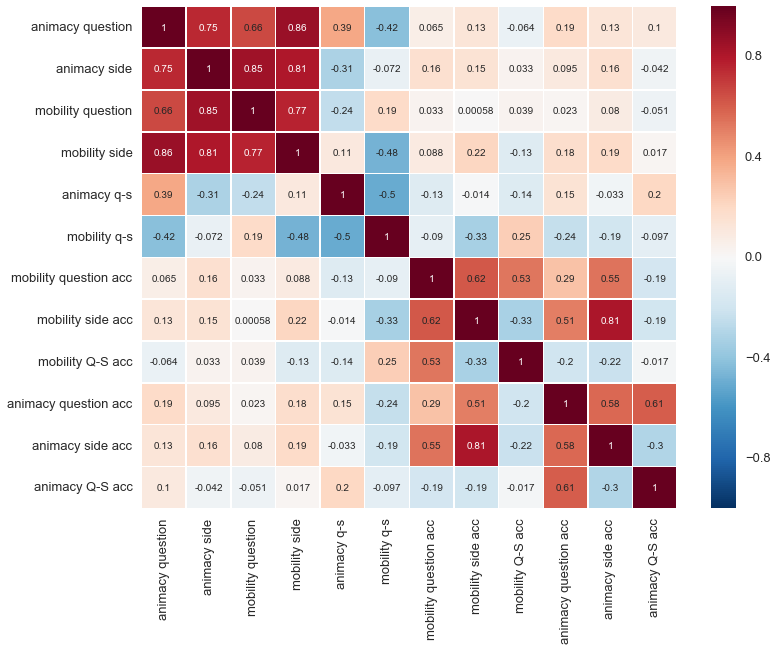

In [122]:
corr = uv_acc.corr()


f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, annot=True, linewidths=.5)
plt.show()


In [123]:
df5_LNL = df5[df5.task == 'animacy']
%Rpush df5_LNL

%R df5_LNL <- ezANOVA(dv=uV, wid=subject, within=cue, between=group, data=df5_LNL)
%R print(df5_LNL)

$ANOVA
     Effect DFn DFd         F          p p<.05          ges
2     group   1  46 3.7527604 0.05887524       0.0664434521
3       cue   1  46 0.1817824 0.67183458       0.0005039715
4 group:cue   1  46 1.9007287 0.17466481       0.0052445657



In [124]:
df5_MI = df5[df5.task == 'mobility']
%Rpush df5_MI

%R df5_MI <- ezANOVA(dv=uV, wid=subject, within=cue, between=group, data=df5_MI)
%R print(df5_MI)

$ANOVA
     Effect DFn DFd        F           p p<.05         ges
2     group   1  46 4.800646 0.033552522     * 0.084032749
3       cue   1  46 8.812984 0.004736857     * 0.022642716
4 group:cue   1  46 2.885562 0.096131828       0.007528365



### The following analyses are conducted using the electrodes found to be significant under Question-Side/Depressed-Controls for the MUT analysis.

In [125]:
# for 400-800 ms
hc_par3 = make_clean_df(path2erps + 'MeanAmps/HC/HC_cueDiff_taskDiff_Par_400_800.txt')
mdd_par3 = make_clean_df(path2erps + 'MeanAmps/MDD/MDD_cueDiff_taskDiff_Par_400_800.txt')
hc_par3['group'] = 'control'
mdd_par3['group'] = 'MDD'
all_par3 = pd.concat([hc_par3,mdd_par3],axis=0)
all_par3.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
0,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,34,E34,-0.081,control
1,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,35,E35,2.240,control
2,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,40,E40,2.227,control
3,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,41,E41,2.679,control
4,SM011,[400.0 800.0],animacy side hit,Side,animacy,left,42,E42,1.070,control


In [143]:
all_par3.electrode_label.unique()

array(['E34', 'E35', 'E40', 'E41', 'E42', 'E46', 'E47', 'P5', 'P3', 'E53'], dtype=object)

In [144]:
# Group x Cue X Task within significant electrodes in MUT analysis
%Rpush all_par3

%R uv_par3 <- aov_ez(dv='uV', id='subject', within=c('task', 'cue'), between='group', data=all_par3)
%R print(uv_par3)

Anova Table (Type 3 tests)

Response: uV
          Effect    df  MSE       F   ges p.value
1          group 1, 46 7.07    0.94   .01     .34
2           task 1, 46 0.71    1.98  .003     .17
3     group:task 1, 46 0.71    0.08 .0001     .78
4            cue 1, 46 0.65    0.98  .001     .33
5      group:cue 1, 46 0.65  3.35 +  .005     .07
6       task:cue 1, 46 1.09    1.88  .005     .18
7 group:task:cue 1, 46 1.09 8.23 **   .02    .006

Sphericity correction method: GG 


In [145]:
# Group x Cue for MI words only . . . 
all_par3_MI = all_par3[all_par3.task == 'mobility']
%Rpush all_par3_MI
%R uv_par_MI <- aov_ez(dv='uV', id='subject', within='cue', between='group', data=all_par3_MI, type=3)
%R print(uv_par_MI)

Anova Table (Type 3 tests)

Response: uV
     Effect    df  MSE         F  ges p.value
1     group 1, 46 3.57      1.11  .02     .30
2       cue 1, 46 0.54      0.37 .001     .54
3 group:cue 1, 46 0.54 18.49 ***  .05  <.0001

Sphericity correction method: GG 


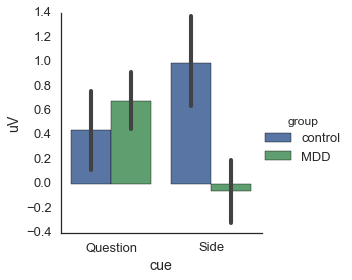

In [148]:
sns.set_style('white')
sns.factorplot(y='uV',x='cue',hue='group',units='subject',ci=68,kind='bar',data=all_par3_MI,
              order=['Question','Side'])
sns.plt.savefig(path2figs + 'Group_x_Cue_MI_MUT_400-800_LeftParElects.pdf')

In [156]:
g = all_par3_MI.groupby(['subject','group','cue'])['uV'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Question')]['uV'],
              df[(df.group == 'MDD') & (df.cue == 'Question')]['uV'],
              paired=False)

misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Side')]['uV'],
              df[(df.group == 'MDD') & (df.cue == 'Side')]['uV'],
              paired=False)

misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Question')]['uV'],
              df[(df.group == 'control') & (df.cue == 'Side')]['uV'],
              paired=True)

misc.ttest_2s(df[(df.group == 'MDD') & (df.cue == 'Question')]['uV'],
              df[(df.group == 'MDD') & (df.cue == 'Side')]['uV'],
              paired=True)

t(46) = -0.64, p = 0.525
t(46) = 2.34, p = 0.023
t(23) = -2.99, p = 0.007
t(23) = 3.12, p = 0.005


(3.1216444636751945, 0.0047950054835911781)

In [160]:
# Group x Cue for LNL words only . . . no significant effects, which is what we want:) 
all_par3_LNL = all_par3[all_par3.task == 'animacy']
%Rpush all_par3_LNL
%R uv_par_LNL <- aov_ez(dv='uV', id='subject', within='cue', between='group', data=all_par3_LNL, type=3)
%R print(uv_par_LNL)

Anova Table (Type 3 tests)

Response: uV
     Effect    df  MSE    F  ges p.value
1     group 1, 46 4.21 0.65  .01     .42
2       cue 1, 46 1.21 2.07 .010     .16
3 group:cue 1, 46 1.21 0.96 .005     .33

Sphericity correction method: GG 


In [129]:
# for 800-1400 ms
hc_par4 = make_clean_df(path2erps + 'MeanAmps/HC/HC_cueDiff_taskDiff_Par_800_1400.txt')
mdd_par4 = make_clean_df(path2erps + 'MeanAmps/MDD/MDD_cueDiff_taskDiff_Par_800_1400.txt')
hc_par4['group'] = 'control'
mdd_par4['group'] = 'MDD'
all_par4 = pd.concat([hc_par4,mdd_par4],axis=0)
all_par4.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
0,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,34,E34,-1.122,control
1,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,35,E35,3.729,control
2,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,40,E40,4.433,control
3,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,41,E41,4.129,control
4,SM011,[800.0 1400.0],animacy side hit,Side,animacy,left,42,E42,0.124,control


In [130]:
%Rpush all_par4

%R uv_par4 <- ezANOVA(dv=uV, wid=subject, within=.(task, cue), between=group, data=all_par4)
%R print(uv_par4)

$ANOVA
          Effect DFn DFd          F          p p<.05          ges
2          group   1  46 4.12704715 0.04800323     * 0.0558015045
3           task   1  46 1.52718468 0.22280931       0.0022125175
5            cue   1  46 0.41516845 0.52255800       0.0010908929
4     group:task   1  46 0.07467883 0.78586560       0.0001084195
6      group:cue   1  46 3.23520924 0.07863430       0.0084382797
7       task:cue   1  46 3.17489389 0.08138012       0.0104826084
8 group:task:cue   1  46 5.09403351 0.02880138     * 0.0167131665



In [157]:
# Group x Cue for MI words only . . . significant interaction, as expected/desired.
all_par4_MI = all_par4[all_par4.task == 'mobility']
%Rpush all_par4_MI
%R uv_par4_MI <- aov_ez(dv='uV', id='subject', within='cue', between='group', data=all_par4_MI)
%R print(uv_par4_MI)

Anova Table (Type 3 tests)

Response: uV
     Effect    df  MSE         F  ges p.value
1     group 1, 46 3.88    3.61 +  .06     .06
2       cue 1, 46 0.89      1.42 .006     .24
3 group:cue 1, 46 0.89 14.38 ***  .06   .0004

Sphericity correction method: GG 


In [158]:
g = all_par4_MI.groupby(['subject','group','cue'])['uV'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
df.head()

misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Question')]['uV'],
              df[(df.group == 'MDD') & (df.cue == 'Question')]['uV'],
              paired=False)

misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Side')]['uV'],
              df[(df.group == 'MDD') & (df.cue == 'Side')]['uV'],
              paired=False)

misc.ttest_2s(df[(df.group == 'control') & (df.cue == 'Question')]['uV'],
              df[(df.group == 'control') & (df.cue == 'Side')]['uV'],
              paired=True)

misc.ttest_2s(df[(df.group == 'MDD') & (df.cue == 'Question')]['uV'],
              df[(df.group == 'MDD') & (df.cue == 'Side')]['uV'],
              paired=True)

t(46) = 0.08, p = 0.936
t(46) = 3.12, p = 0.003
t(23) = -2.02, p = 0.055
t(23) = 3.25, p = 0.003


(3.2537877458615392, 0.003497897074855448)

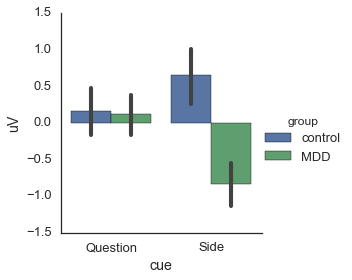

In [159]:
sns.factorplot(y='uV',x='cue',hue='group',units='subject',ci=68,kind='bar',data=all_par4_MI,
              order=['Question','Side'])
sns.plt.savefig(path2figs + 'Group_x_Cue_MI_MUT_800-1400_LeftParElects.pdf')

In [161]:
# Group x Cue for LNL words only . . . no significant effects (good), but there is a nearly significant effect of
# Group . . . plot in next cell shows it is due to weaker response in MDDs, overall.
all_par4_LNL = all_par4[all_par4.task == 'animacy']
%Rpush all_par4_LNL
%R uv_par4_LNL <- aov_ez(dv='uV', id='subject', within='cue', between='group', data=all_par4_LNL)
%R print(uv_par4_LNL)

Anova Table (Type 3 tests)

Response: uV
     Effect    df  MSE      F  ges p.value
1     group 1, 46 4.27 3.89 +  .05     .05
2       cue 1, 46 2.19   2.18  .02     .15
3 group:cue 1, 46 2.19   0.17 .001     .68

Sphericity correction method: GG 


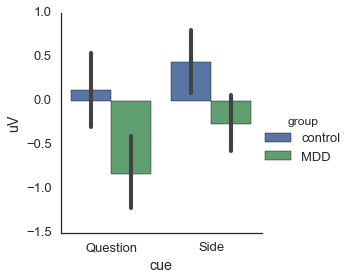

In [162]:
sns.factorplot(y='uV',x='cue',hue='group',units='subject',ci=68,kind='bar',data=all_par4_LNL,
              order=['Question','Side'])

###Follow-up tests on the group difference in Q-S uV in each time window . . .  

#### 400-800 ms 

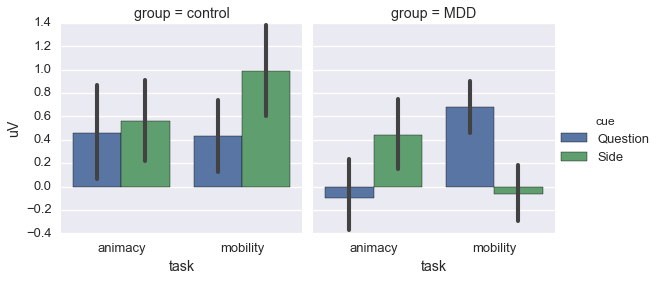

In [133]:
sns.factorplot(y='uV', x='task', hue='cue',col='group',units='subject',ci=68, kind='bar', data=all_par3,
              hue_order=['Question','Side'])

In [134]:
all_par3_MI.head()
g = all_par3_MI.groupby(['subject','group','cue'])['uV'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
par_table_MI = df.pivot_table(index=['subject','group'],columns='cue',values='uV')
par_table_MI.reset_index(inplace=True)
new_cols = ['subject','group','question','side']
par_table_MI.columns = new_cols
par_table_MI['Q-S'] = par_table_MI['question']-par_table_MI['side']
par_table_MI['condition'] = 'mobility'
par_table_MI.head()

,subject,group,question,side,Q-S,condition
0,SM011,control,0.9477,0.9382,0.0095,mobility
1,SM013,control,0.7688,1.0773,-0.3085,mobility
2,SM014,control,0.1516,0.0330,0.1186,mobility
3,SM015,MDD,1.0759,1.3718,-0.2959,mobility
4,SM017,control,1.8646,3.3084,-1.4438,mobility


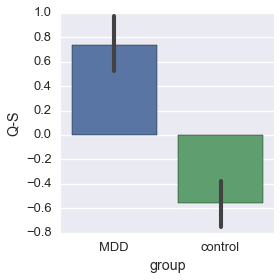

In [135]:
#Question-side for mobility uV 400-800 ms
sns.factorplot(y='Q-S',x='group',units='subject',ci=68,kind='bar',data=par_table_MI,
              order = ['MDD','control'])

In [136]:
misc.ttest_2s(par_table_MI[par_table_MI.group == 'control']['Q-S'],
             par_table_MI[par_table_MI.group == 'MDD']['Q-S'])

t(46) = -4.30, p = 0.000


(-4.2999436302497998, 8.7990055988736857e-05)

#### 800-1400 ms 

In [137]:
all_par4_MI.head()

,subject,time,condition,cue,task,laterality,electrode,electrode_label,uV,group
10,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,34,E34,-1.098,control
11,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,35,E35,1.106,control
12,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,40,E40,0.303,control
13,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,41,E41,-0.100,control
14,SM011,[800.0 1400.0],mobility side hit,Side,mobility,left,42,E42,1.710,control


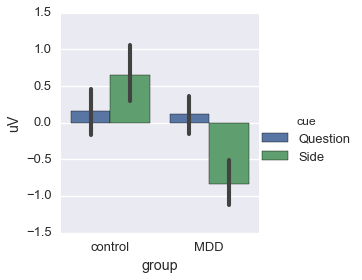

In [138]:
sns.factorplot(y='uV', x='group',hue='cue',units='subject',ci=68, kind='bar', data=all_par4_MI,
              hue_order=['Question','Side'])

In [139]:
g = all_par4_MI.groupby(['subject','group','cue'])['uV'].mean()
df = g.to_frame()
df.reset_index(inplace=True)
par_MI_800_1400 = df.pivot_table(index=['subject','group'],columns='cue',values='uV')
par_MI_800_1400.reset_index(inplace=True)
par_MI_800_1400['Q-S'] = par_MI_800_1400.Question - par_MI_800_1400.Side
par_MI_800_1400.head()

cue,subject,group,Question,Side,Q-S
0,SM011,control,-0.3020,1.2277,-1.5297
1,SM013,control,0.6920,-0.0581,0.7501
2,SM014,control,-0.6669,-0.5852,-0.0817
3,SM015,MDD,-0.5459,0.5763,-1.1222
4,SM017,control,1.7799,3.1162,-1.3363


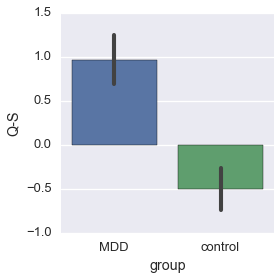

In [140]:
sns.factorplot(y='Q-S',x='group',units='subject',ci=68,kind='bar',data=par_MI_800_1400,
              order = ['MDD','control'])

In [141]:
misc.ttest_2s(par_MI_800_1400[par_MI_800_1400.group == 'control']['Q-S'],
              par_MI_800_1400[par_MI_800_1400.group == 'MDD']['Q-S'],
              paired=False)

t(46) = -3.79, p = 0.000


(-3.7918051944278517, 0.00043421063718707467)

### Correlations b/w behavior and uV from the MUT Q-S/mobility electrodes

I started doing this and was getting different results than are in the BP paper, and I realized why . . . here I start with the electrodes that showed group differences in the MUT Q-S/MI analysis, and in the BP paper I used electrodes that showed significant MUT Q-S/MI differences in the MDD group considered alone. I think the second approach (the one in the BP paper) is the better one, so I'll switch back to that below . . . 

In [167]:
sr.head()

Item,subject,Group,Age,Gender,Race,Ethnicity,Marital_Status,Education_Level,Education_Years,Occupation,...,PSQI_Duration,PSQI_Disturb,PSQI_Latency,PSQI_DayDys,PSQI_Efficiency,PSQI_Quality,PSQI_Medication,PSQI_Total,WTAR_NatEng,WTAR_StdScore
0,SM011,0,26,f,3,0,never married,four year college,16,stay at home mom,...,0,1,0,0,0,0,0,1,yes,89
1,SM012,0,26,f,5,0,never married,four year college,16,artist,...,0,1,0,0,0,0,0,1,yes,127
2,SM013,0,55,f,5,0,never married,graduate or professional school,18,volunteer coordinator,...,1,1,0,0,0,1,0,3,yes,122
3,SM014,0,27,m,5,1,never married,graduate or professional school,17,student,...,0,1,0,0,0,1,0,2,yes,121
4,SM015,1,43,f,5,0,separated,high school,12,chef,...,2,2,2,2,2,1,1,12,yes,96


In [168]:
sr.columns

Index([        u'subject',           u'Group',             u'Age',
                u'Gender',            u'Race',       u'Ethnicity',
        u'Marital_Status', u'Education_Level', u'Education_Years',
            u'Occupation',  u'Highest Degree',          u'Income',
                 u'Notes',       u'Inclusion',       u'BDI_total',
              u'MASQ_GDA',         u'MASQ_AA',        u'MASQ_GDD',
               u'MASQ_AD',         u'RSQ_Dep',       u'RSQ_Brood',
           u'RSQ_Reflect',   u'PSQI_Duration',    u'PSQI_Disturb',
          u'PSQI_Latency',     u'PSQI_DayDys', u'PSQI_Efficiency',
          u'PSQI_Quality', u'PSQI_Medication',      u'PSQI_Total',
           u'WTAR_NatEng',   u'WTAR_StdScore'],
      dtype='object', name=u'Item')

In [306]:
table_MI.head()

,subject,group,Question,Side,Q-S,condition,WTAR_NatEng,WTAR_StdScore
0,SM011,control,0.304348,0.434783,-0.130435,mobility,yes,89
1,SM013,control,0.717391,0.700000,0.017391,mobility,yes,122
2,SM014,control,0.744186,0.869565,-0.125379,mobility,yes,121
3,SM015,MDD,0.765957,0.541667,0.224291,mobility,yes,96
4,SM017,control,0.854167,0.860465,-0.006298,mobility,yes,128


In [307]:
# Okay, let's put together a df for individual differences that's a bit cleaner . . . 
df = table_MI[['subject','group','Q-S']]
new_cols = ['subject','Group','QvS_acc']
df.columns = new_cols
df.head()

,subject,Group,QvS_acc
0,SM011,control,-0.130435
1,SM013,control,0.017391
2,SM014,control,-0.125379
3,SM015,MDD,0.224291
4,SM017,control,-0.006298


In [308]:
# Now get the Q-S left parietal diffs from 400-800 ms
g = all_par3_MI.groupby(['subject','cue'])['uV'].mean()
h = g.to_frame()
h.reset_index(inplace=True)
piv = pd.pivot_table(h,index='subject',columns='cue',values='uV')
piv.reset_index(inplace=True)
piv['QvS_400-800'] = piv.Question - piv.Side
lp48 = piv[['subject','QvS_400-800']]
lp48

cue,subject,QvS_400-800
0,SM011,0.0095
1,SM013,-0.3085
2,SM014,0.1186
3,SM015,-0.2959
4,SM017,-1.4438
5,SM018,-0.2487
6,SM019,-1.4804
7,SM021,1.1498
8,SM022,-1.0903
9,SM023,-0.0412


In [309]:
# Now get the Q-S left parietal diffs from 800-1400 ms
g = all_par4_MI.groupby(['subject','cue'])['uV'].mean()
h = g.to_frame()
h.reset_index(inplace=True)
piv = pd.pivot_table(h,index='subject',columns='cue',values='uV')
piv.reset_index(inplace=True)
piv['QvS_800-1400'] = piv.Question - piv.Side
lp814 = piv[['subject','QvS_800-1400']]
lp814

cue,subject,QvS_800-1400
0,SM011,-1.5297
1,SM013,0.7501
2,SM014,-0.0817
3,SM015,-1.1222
4,SM017,-1.3363
5,SM018,0.2964
6,SM019,-1.2343
7,SM021,1.6346
8,SM022,0.1731
9,SM023,0.0340


In [310]:
# Now merge all that
df = pd.merge(df,lp48,on='subject')
df = pd.merge(df,lp814,on='subject')
df.head()

,subject,Group,QvS_acc,QvS_400-800,QvS_800-1400
0,SM011,control,-0.130435,0.0095,-1.5297
1,SM013,control,0.017391,-0.3085,0.7501
2,SM014,control,-0.125379,0.1186,-0.0817
3,SM015,MDD,0.224291,-0.2959,-1.1222
4,SM017,control,-0.006298,-1.4438,-1.3363


In [311]:
# Now add the self-report
indiffs = pd.merge(df,sr,on='subject')
del indiffs['Group_y']
indiffs.rename(columns={'Group_x':'Group'},inplace=True)
indiffs.head()

,subject,Group,QvS_acc,QvS_400-800,QvS_800-1400,Age,Gender,Race,Ethnicity,Marital_Status,...,PSQI_Duration,PSQI_Disturb,PSQI_Latency,PSQI_DayDys,PSQI_Efficiency,PSQI_Quality,PSQI_Medication,PSQI_Total,WTAR_NatEng,WTAR_StdScore
0,SM011,control,-0.130435,0.0095,-1.5297,26,f,3,0,never married,...,0,1,0,0,0,0,0,1,yes,89
1,SM013,control,0.017391,-0.3085,0.7501,55,f,5,0,never married,...,1,1,0,0,0,1,0,3,yes,122
2,SM014,control,-0.125379,0.1186,-0.0817,27,m,5,1,never married,...,0,1,0,0,0,1,0,2,yes,121
3,SM015,MDD,0.224291,-0.2959,-1.1222,43,f,5,0,separated,...,2,2,2,2,2,1,1,12,yes,96
4,SM017,control,-0.006298,-1.4438,-1.3363,22,f,"2,5",0,never married,...,0,1,1,1,0,2,0,5,yes,128


In [312]:
indiffs_dep.head()

,subject,Group,QvS_acc,QvS_400-800,QvS_800-1400,Age,Gender,Race,Ethnicity,Marital_Status,...,PSQI_DayDys,PSQI_Efficiency,PSQI_Quality,PSQI_Medication,PSQI_Total,WTAR_NatEng,WTAR_StdScore,400_800,800_1400,1400_2000
0,SM015,MDD,0.224291,-0.2959,-1.1222,43,f,5,0,separated,...,2,2,1,1,12,yes,96,1.342083,2.504034,2.394250
1,SM026,MDD,0.063701,-0.1474,-1.0437,46,m,5,0,never married,...,1,0,1,0,NaN,yes,125,0.598833,0.547379,0.627083
2,SM031,MDD,-0.012698,-0.0971,1.2813,27,m,5,0,"married, or living with someone as if married",...,2,1,2,0,10,yes,113,1.185083,1.744655,1.735667
3,SM037,MDD,-0.002525,0.4982,0.1660,32,m,2,0,"married, or living with someone as if married",...,2,0,2,0,7,yes,127,0.490083,0.636000,0.470417
4,SM038,MDD,0.107927,-0.3039,1.4246,20,f,5,0,never married,...,1,0,1,1,6,yes,120,0.498125,3.269138,3.724583


In [313]:
indiffs_dep['QvS_400-800'].describe()

count    24.000000
mean      0.738750
std       1.159364
min      -0.558300
25%      -0.109675
50%       0.767750
75%       1.273050
max       4.871100
Name: QvS_400-800, dtype: float64

In [314]:
# First let's look at correlations between Q-S accuracy and Q-S ERPs over both groups.
# The ERPs in both windows are strongly correlated and accuracy is positively correlated with the 800-1400 ms window
%Rpush indiffs
%R print(cor.test(indiffs$QvS_acc,indiffs$QvS_400-800))
%R print(cor.test(indiffs$QvS_acc,indiffs$QvS_800-1400))
%R print(cor.test(indiffs$QvS_400-800,indiffs$QvS_800-1400))


	Pearson's product-moment correlation

data:  indiffs$QvS_acc and indiffs$QvS_400 - 800
t = 1.2732, df = 46, p-value = 0.2093
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1051468  0.4452912
sample estimates:
   cor 
0.1845 




	Pearson's product-moment correlation

data:  indiffs$QvS_acc and indiffs$QvS_800 - 1400
t = 2.0099, df = 46, p-value = 0.05033
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -1.192447e-05  5.258101e-01
sample estimates:
      cor 
0.2841237 




	Pearson's product-moment correlation

data:  indiffs$QvS_400 - 800 and indiffs$QvS_800 - 1400
t = 10.308, df = 46, p-value = 1.539e-13
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7228170 0.9047621
sample estimates:
     cor 
0.835383 



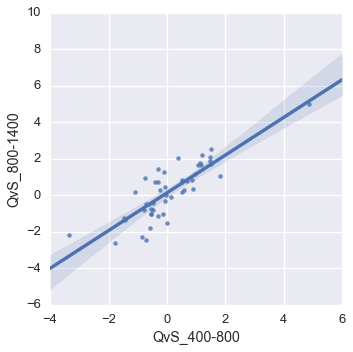

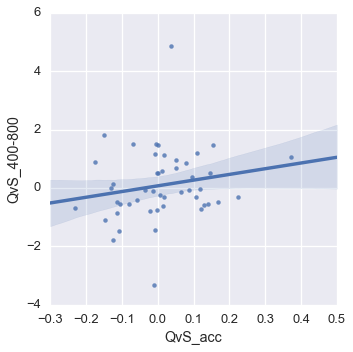

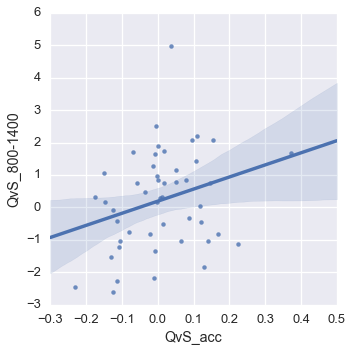

In [315]:
sns.lmplot(x='QvS_400-800', y='QvS_800-1400', data=indiffs, fit_reg=True)
sns.lmplot(x='QvS_acc', y='QvS_400-800', data=indiffs, fit_reg=True)
sns.lmplot(x='QvS_acc', y='QvS_800-1400', data=indiffs, fit_reg=True)

In [316]:
# Okay, now let's run correlations with accuracy in the MDD group alone
# Interesting: significant effects for MASQ-GDA and MASQ-AA, not expected but in line with a reviewer's suggestion

indiffs_dep = indiffs[indiffs.Group == 'MDD']
%Rpush indiffs_dep
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$BDI_total))
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$RSQ_Brood))
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$MASQ_GDA))
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$MASQ_AA))
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$MASQ_AD))
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$PSQI_Total))


	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$BDI_total
t = -1.7687, df = 22, p-value = 0.09081
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.66200892  0.05894856
sample estimates:
       cor 
-0.3528385 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$RSQ_Brood
t = 0.83841, df = 22, p-value = 0.4108
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2448125  0.5409597
sample estimates:
      cor 
0.1759616 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$MASQ_GDA
t = -2.2004, df = 22, p-value = 0.03857
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.70698660 -0.02572917
sample estimates:
       cor 
-0.4247177 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$MASQ_AA
t = -2.5062, df = 22, p-value = 0.02009
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.73494480 -0.08380097
sample estimates:
       cor 
-0.4712665 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$MASQ_AD
t = 0.88831, df = 22, p-value = 0.384
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2349527  0.5483182
sample estimates:
      cor 
0.1860806 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$PSQI_Total
t = -0.82486, df = 21, p-value = 0.4187
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5492476  0.2535652
sample estimates:
       cor 
-0.1771531 



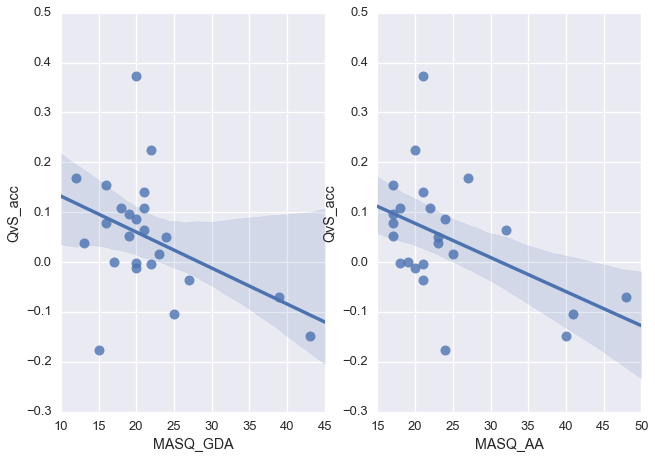

In [317]:
sns.set_style('darkgrid')
fig = plt.figure()
fig.add_subplot(121)
sns.regplot(y='QvS_acc',x='MASQ_GDA',data=indiffs_dep,scatter_kws={"s": 100})
fig.add_subplot(122)
sns.regplot(y='QvS_acc',x='MASQ_AA',data=indiffs_dep,scatter_kws={"s": 100})
plt.savefig('/Users/danieldillon/Work/Expts/SOURCE/Manuscript/source-mem-paper/Figures/Components/' +
            'MDD_AccAnxiety.pdf')

Okay, so now I'm switching to the ERPs that showed Q-S/MI diffs in MDDs considered alone . . . 

In [318]:
def clean_input(fname):
    '''Read in one of the Q-S mean amps files, return a df with mean amps and Subject, Latency as columns.'''
    latency = re.split('bins18[0-9]_',fname)[1]
    latency = latency.split('.txt')[0]
    
    df = pd.read_csv(fname,sep='\t',skipinitialspace=True)
    df['Subject'] = df.ERPset.map(lambda x: x.strip('_ERPs'))
    df = df[['Subject','value']]
    g = df.groupby(['Subject'])['value'].mean()
    df = g.to_frame()
    df.reset_index(inplace=True)
    df.rename(columns={'value':latency},inplace=True)
    return df

In [319]:
%cd /Users/danieldillon/Work/Expts/SOURCE/Analysis/ERPs/MeanAmps/MDD/

/Users/danieldillon/Work/Expts/SOURCE/Analysis/ERPs/MeanAmps/MDD


In [320]:
!ls MDD_Sig*

MDD_SigLeftPar_bins180_1400-2000.txt MDD_SigLeftPar_bins181_1400-2000.txt
MDD_SigLeftPar_bins180_400-800.txt   MDD_SigLeftPar_bins181_400-800.txt
MDD_SigLeftPar_bins180_800-1400.txt  MDD_SigLeftPar_bins181_800-1400.txt


In [321]:
dfs = []
fnames = !ls MDD_SigLeftPar_bins180*
for fname in fnames:
    df = clean_input(fname)
    dfs.append(df)
df = pd.concat(dfs,axis=1)
df = df[['Subject','400-800','800-1400','1400-2000']]
df = df.iloc[:,[0,3,4,5]]
new_cols = ['subject','QvS_400_800','QvS_800_1400','QvS_1400_2000']
df.columns = new_cols
df.head()

,subject,QvS_400_800,QvS_800_1400,QvS_1400_2000
0,SM015,1.342083,2.504034,2.394250
1,SM026,0.598833,0.547379,0.627083
2,SM031,1.185083,1.744655,1.735667
3,SM037,0.490083,0.636000,0.470417
4,SM038,0.498125,3.269138,3.724583


In [322]:
indiffs_dep = pd.merge(indiffs_dep,df,on='subject')

In [327]:
# Delete the ERPs from electrodes that showed group differences as their names are very similar to the electrodes
# that showed condition effects in the MDD group alone
del indiffs_dep['QvS_400-800']
del indiffs_dep['QvS_800-1400']
indiffs_dep.head()

,subject,Group,QvS_acc,Age,Gender,Race,Ethnicity,Marital_Status,Education_Level,Education_Years,...,PSQI_DayDys,PSQI_Efficiency,PSQI_Quality,PSQI_Medication,PSQI_Total,WTAR_NatEng,WTAR_StdScore,QvS_400_800,QvS_800_1400,QvS_1400_2000
0,SM015,MDD,0.224291,43,f,5,0,separated,high school,12,...,2,2,1,1,12,yes,96,1.342083,2.504034,2.394250
1,SM026,MDD,0.063701,46,m,5,0,never married,four year college,16,...,1,0,1,0,NaN,yes,125,0.598833,0.547379,0.627083
2,SM031,MDD,-0.012698,27,m,5,0,"married, or living with someone as if married",four year college,16,...,2,1,2,0,10,yes,113,1.185083,1.744655,1.735667
3,SM037,MDD,-0.002525,32,m,2,0,"married, or living with someone as if married",graduate or professional school,19,...,2,0,2,0,7,yes,127,0.490083,0.636000,0.470417
4,SM038,MDD,0.107927,20,f,5,0,never married,some college,15,...,1,0,1,1,6,yes,120,0.498125,3.269138,3.724583


In [325]:
%Rpush indiffs_dep
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$QvS_400_800))
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$QvS_800_1400))
%R print(cor.test(indiffs_dep$QvS_acc,indiffs_dep$QvS_1400_2000))


	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$QvS_400_800
t = -0.13468, df = 22, p-value = 0.8941
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4271534  0.3790835
sample estimates:
        cor 
-0.02870247 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$QvS_800_1400
t = 0.75701, df = 22, p-value = 0.4571
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.2608272  0.5287458
sample estimates:
      cor 
0.1593341 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_acc and indiffs_dep$QvS_1400_2000
t = 1.5701, df = 22, p-value = 0.1307
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.09858841  0.63900408
sample estimates:
      cor 
0.3174327 



In [330]:
# First check if ERPs are strongly correlated across windows . . . 
# Yes, although 40-800 and 1400-2000 is p = 0.05
%Rpush indiffs_dep
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$QvS_800_1400))
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$QvS_1400_2000))
%R print(cor.test(indiffs_dep$QvS_800_1400,indiffs_dep$QvS_1400_2000))


	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$QvS_800_1400
t = 7.165, df = 22, p-value = 3.498e-07
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6540090 0.9271462
sample estimates:
     cor 
0.836671 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$QvS_1400_2000
t = 2.0514, df = 22, p-value = 0.05232
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.003208701  0.692211689
sample estimates:
      cor 
0.4007067 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_800_1400 and indiffs_dep$QvS_1400_2000
t = 4.5646, df = 22, p-value = 0.0001519
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4091452 0.8591220
sample estimates:
      cor 
0.6974323 



In [328]:
# Now run correlations with ERP amplitudes from 400-800 ms in the MDD group alone
# Only sig relationship is with PSQI

%Rpush indiffs_dep
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$BDI_total))
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$RSQ_Brood))
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$MASQ_GDA))
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$MASQ_AA))
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$MASQ_AD))
%R print(cor.test(indiffs_dep$QvS_400_800,indiffs_dep$PSQI_Total))


	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$BDI_total
t = -1.3023, df = 22, p-value = 0.2063
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.6055763  0.1522981
sample estimates:
       cor 
-0.2675351 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$RSQ_Brood
t = 0.43392, df = 22, p-value = 0.6686
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3232911  0.4777621
sample estimates:
       cor 
0.09211929 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$MASQ_GDA
t = -0.75351, df = 22, p-value = 0.4591
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5282146  0.2615140
sample estimates:
       cor 
-0.1586157 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$MASQ_AA
t = -0.45267, df = 22, p-value = 0.6552
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4808274  0.3197230
sample estimates:
        cor 
-0.09606355 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$MASQ_AD
t = -0.18625, df = 22, p-value = 0.854
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4360932  0.3696365
sample estimates:
        cor 
-0.03967632 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_400_800 and indiffs_dep$PSQI_Total
t = -2.5374, df = 21, p-value = 0.01916
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.74737971 -0.09022399
sample estimates:
       cor 
-0.4844107 



In [329]:
# Now run correlations with ERP amplitudes from 800-1400 ms in the MDD group alone
# Again, only sig relationship is with PSQI

%Rpush indiffs_dep
%R print(cor.test(indiffs_dep$QvS_800_1400,indiffs_dep$BDI_total))
%R print(cor.test(indiffs_dep$QvS_800_1400,indiffs_dep$RSQ_Brood))
%R print(cor.test(indiffs_dep$QvS_800_1400,indiffs_dep$MASQ_GDA))
%R print(cor.test(indiffs_dep$QvS_800_1400,indiffs_dep$MASQ_AA))
%R print(cor.test(indiffs_dep$QvS_800_1400,indiffs_dep$MASQ_AD))
%R print(cor.test(indiffs_dep$QvS_800_1400,indiffs_dep$PSQI_Total))


	Pearson's product-moment correlation

data:  indiffs_dep$QvS_800_1400 and indiffs_dep$BDI_total
t = -1.0676, df = 22, p-value = 0.2973
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5739455  0.1993078
sample estimates:
       cor 
-0.2219323 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_800_1400 and indiffs_dep$RSQ_Brood
t = 0.2208, df = 22, p-value = 0.8273
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3632644  0.4420349
sample estimates:
       cor 
0.04702311 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_800_1400 and indiffs_dep$MASQ_GDA
t = -0.67443, df = 22, p-value = 0.5071
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5160917  0.2769730
sample estimates:
       cor 
-0.1423257 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_800_1400 and indiffs_dep$MASQ_AA
t = -0.73199, df = 22, p-value = 0.4719
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5249389  0.2657314
sample estimates:
       cor 
-0.1541942 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_800_1400 and indiffs_dep$MASQ_AD
t = -0.41543, df = 22, p-value = 0.6819
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.474726  0.326803
sample estimates:
       cor 
-0.0882245 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_800_1400 and indiffs_dep$PSQI_Total
t = -2.6292, df = 21, p-value = 0.01568
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.7549821 -0.1075018
sample estimates:
       cor 
-0.4976518 



In [331]:
# Now run correlations with ERP amplitudes from 1400-2000 ms in the MDD group alone

%Rpush indiffs_dep
%R print(cor.test(indiffs_dep$QvS_1400_2000,indiffs_dep$BDI_total))
%R print(cor.test(indiffs_dep$QvS_1400_2000,indiffs_dep$RSQ_Brood))
%R print(cor.test(indiffs_dep$QvS_1400_2000,indiffs_dep$MASQ_GDA))
%R print(cor.test(indiffs_dep$QvS_1400_2000,indiffs_dep$MASQ_AA))
%R print(cor.test(indiffs_dep$QvS_1400_2000,indiffs_dep$MASQ_AD))
%R print(cor.test(indiffs_dep$QvS_1400_2000,indiffs_dep$PSQI_Total))


	Pearson's product-moment correlation

data:  indiffs_dep$QvS_1400_2000 and indiffs_dep$BDI_total
t = 0.044149, df = 22, p-value = 0.9652
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3954861  0.4112475
sample estimates:
        cor 
0.009412264 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_1400_2000 and indiffs_dep$RSQ_Brood
t = -0.054913, df = 22, p-value = 0.9567
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4131524  0.3935485
sample estimates:
        cor 
-0.01170674 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_1400_2000 and indiffs_dep$MASQ_GDA
t = 0.45608, df = 22, p-value = 0.6528
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3190730  0.4813837
sample estimates:
       cor 
0.09678068 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_1400_2000 and indiffs_dep$MASQ_AA
t = -0.58377, df = 22, p-value = 0.5653
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.5018989  0.2945645
sample estimates:
       cor 
-0.1235082 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_1400_2000 and indiffs_dep$MASQ_AD
t = -0.0028392, df = 22, p-value = 0.9978
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4039034  0.4028898
sample estimates:
          cor 
-0.0006053295 




	Pearson's product-moment correlation

data:  indiffs_dep$QvS_1400_2000 and indiffs_dep$PSQI_Total
t = -0.31993, df = 21, p-value = 0.7522
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.4683999  0.3526825
sample estimates:
        cor 
-0.06964437 



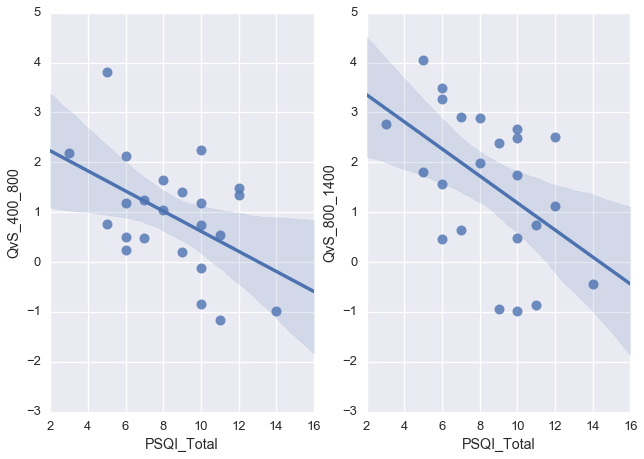

In [333]:
fig = plt.figure()
fig.add_subplot(121)
sns.regplot(y='QvS_400_800',x='PSQI_Total',data=indiffs_dep,scatter_kws={"s": 100})
fig.add_subplot(122)
sns.regplot(y='QvS_800_1400',x='PSQI_Total',data=indiffs_dep,scatter_kws={"s": 100})
plt.savefig('/Users/danieldillon/Work/Expts/SOURCE/Manuscript/source-mem-paper/Figures/Components/' +
            'MDD_ERP_PSQI.pdf')

### Congruency sequence 

This is **low priority**--only one reviewer mentioned it and I've never found anything great with this . . . 

One way this will differ from what I did before is that this time, at the reviewer's suggestion, I'm including the Odd/Even trials . . . 

The basic question is, can healthy and depressed adults reconfigure set just as easily or no? Let's keep it simple at first, just add a 'cue_1back' column that is either "same" or "different". May ultimately be worthwhile to split this up further to look at switches into or out of an episodic (or conceptual/perceptual) set, but let's start with the basics.

In [ ]:
dfs = []
for sub in erp_ret.subject.unique():
    df = erp_ret[erp_ret.subject == sub]
    df['cue_1b'] = df.cue.shift(1)
    dfs.append(df)
erp_ret = pd.concat(dfs)
erp_ret[['cue','cue_1b']].head()

In [ ]:
def AddSetSwitch(data):
    '''If cue on current trial and trial 1back are same, no switch, otherwise switch.'''
    cue, cue_1b = data
    if pd.isnull(cue) or pd.isnull(cue_1b):
        switch = np.nan
    elif cue == cue_1b:
        switch = 'no'
    else:
        switch = 'yes'
    
    return switch

In [ ]:
erp_ret['switch'] = erp_ret[['cue','cue_1b']].apply(AddSetSwitch,axis=1)

In [ ]:
erp_ret[['cue','cue_1b','switch']].head()

In [ ]:
# First question: is guessing affected by switching? Looks like you might have a Group x Switch interaction there.
sns.factorplot(y='guess',x='switch',hue='group',units='subject',ci=68,kind='bar',
               data=erp_ret)

In [ ]:
# This shows a trend for a group difference in guessing, but neither the switch effect nor the GxS is sig.
erp_ret['switch_FX'] = erp_ret.switch.replace(to_replace={'no':-1,'yes':1})
erp_switch = erp_ret[(erp_ret.switch == 'no') | (erp_ret.switch == 'yes')]

%Rpush erp_switch
%R erp_switch$group_FX <- as.factor(erp_switch$group_FX)
%R erp_switch$gender_FX <- as.factor(erp_switch$gender_FX)
%R erp_switch$switch_FX <- as.factor(erp_switch$switch_FX)

%R switch_guess <- glmer(guess ~ Age + gender_FX + group_FX*switch_FX + (1|word) + (1|subject),\
                         glmerControl(optimizer="bobyqa", optCtrl = list(maxfun = 100000)),\
                         family=binomial, data=erp_switch)

%R print(summary(switch_guess))                         

In [ ]:
# How about accuracy once guesses are removed? Maybe a tiny negative effect . . . 
sns.factorplot(y='accuracy',x='switch',hue='group',units='subject',ci=68,kind='bar',
               data=erp_switch[~(erp_switch.response == 3)])

In [ ]:
# Big effects of Age and Gender on accuracy, but no effect of Group or Switch and no interaction . . . 
erp_switch_nog = erp_switch[~(erp_switch.response == 3)]

%Rpush erp_switch_nog
%R erp_switch_nog$group_FX <- as.factor(erp_switch_nog$group_FX)
%R erp_switch_nog$gender_FX <- as.factor(erp_switch_nog$gender_FX)
%R erp_switch_nog$switch_FX <- as.factor(erp_switch_nog$switch_FX)

%R switch_acc <- glmer(accuracy ~ Age + gender_FX + group_FX*switch_FX + (1|word) + (1|subject),\
                         glmerControl(optimizer="bobyqa", optCtrl = list(maxfun = 100000)),\
                         family=binomial, data=erp_switch_nog)

%R print(summary(switch_acc))                         

In [ ]:
# How about RT? Looks like a slow-down
sns.factorplot(y='RT',x='switch',hue='group',units='subject',ci=68,kind='bar',
               data=erp_switch_nog)

In [ ]:
# Strong effects of Gender and Switch on RT, there is also a Group x Switch interaction but judging by the graph,
# the follow-ups would not be significant.

%R switch_RT <- lmer(RT ~ Age + gender_FX + group_FX*switch_FX + (1|word) + (1|subject), data=erp_switch_nog)

%R print(summary(switch_RT))                         

In [ ]:
# How about confidence? doesn't look like much of an effect there . . . 
sns.factorplot(y='high_confidence',x='switch',hue='group',units='subject',ci=68,kind='bar',
               data=erp_switch_nog)

In [ ]:
# There is a reliable effect of switching on confidence . . . 
%R switch_conf <- glmer(high_confidence ~ Age + gender_FX + group_FX*switch_FX + (1|word) + (1|subject),\
                         glmerControl(optimizer="bobyqa", optCtrl = list(maxfun = 100000)),\
                         family=binomial, data=erp_switch_nog)

%R print(summary(switch_conf))                         